In [1]:
# Multiple seeds per experiment

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import permutations, combinations
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
import pickle

DEVICE = "cpu"

In [2]:
class Sender(nn.Module):

    def __init__(self, num_concepts, hidden_size, device, num_layers=1, 
                 vocab_size=5, max_len=10, top_p=0.9, dropout_p=0, 
                 decoding_strategy="gumbel_softmax"):
        super().__init__()

        self.encoder = nn.Linear(num_concepts, hidden_size)
        self.grus = nn.ModuleList([nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size) for _ in range(num_layers)])
        self.output = nn.Linear(hidden_size, vocab_size) # applied at every time step
        self.vocab_encoder = nn.Linear(vocab_size, hidden_size, bias=False)
        self.dropout = nn.Dropout(p=dropout_p)
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.max_len = max_len
        self.top_p = top_p
        self.decoding_strategy = decoding_strategy
        assert self.decoding_strategy in ["top_p", "sampling", "greedy", "gumbel_softmax"]
    
    def top_p_sampling(self, output):
        sorted_probabilities, sorted_indices = torch.sort(output, descending=True)
        cumulative_probabilities = torch.cumsum(sorted_probabilities, dim=0)
        top_p_mask = cumulative_probabilities <= self.top_p
        top_p_probabilities = sorted_probabilities[top_p_mask]
        top_p_indices = sorted_indices[top_p_mask]
        if len(top_p_probabilities) == 0: # If top_p is too low, fall back to greedy decoding
            next_token = torch.argmax(output) 
        else:
            next_token = top_p_indices[torch.multinomial(top_p_probabilities, 1).item()]
        return next_token

    def forward(self, x, eval=False, temperature=1.0):
        h_0 = self.encoder(x)
        latest_token = torch.zeros(self.hidden_size).to(self.device) # Not the same as token 0, it is an embedding state of all zeros
        # latest_token = torch.randn(self.hidden_size).to(self.device) 

        hidden_states = [h_0.clone() for _ in range(self.num_layers)]

        output_states = torch.zeros((self.max_len, self.vocab_size)).to(self.device)
        decoded_outputs = []

        for i in range(self.max_len-1):

            hidden_states[0] = self.grus[0](latest_token, hidden_states[0])
            for j in range(1, self.num_layers):
                x = self.grus[j](hidden_states[j-1], hidden_states[j])
                hidden_states[j] = x

            if not eval:
                logits = self.output(self.dropout(hidden_states[self.num_layers-1]))
                if self.decoding_strategy=="gumbel_softmax":
                    gumbel_logits = -torch.log(-torch.log(torch.rand_like(logits))) # sample from Gumbel(0, 1)
                    logits = (logits+gumbel_logits)/temperature
            else:
                logits = self.output(hidden_states[self.num_layers-1])
            
            # GRADIENT FLOW THROUGH GUMBEL SAMPLING and STRAIGHT THROUGH ESTIMATOR
            
            output = torch.softmax(logits, dim = 0)
            
            if self.decoding_strategy == "greedy":
                decoded = torch.argmax(output)
            elif self.decoding_strategy=="sampling":
                decoded = torch.multinomial(output, num_samples=1, replacement=True)[0]
            elif self.decoding_strategy=="top_p":
                decoded = self.top_p_sampling(output)
            elif self.decoding_strategy=="gumbel_softmax":
                decoded = torch.argmax(output)
                output_hard = torch.zeros_like(output)
                output_hard[decoded] = 1.0
                output = output_hard + output - output.detach() # Straight-through estimator removes content, keeps gradient

            output_states[i] = output
            decoded_outputs.append(decoded.item())
            
            if decoded.item() == 0: # EOS token detected
                break

            latest_token = self.vocab_encoder(output)
        
        decoded_outputs = decoded_outputs + [0]*(self.max_len-len(decoded_outputs)) # 0 = END TOKEN
        assert len(decoded_outputs) == self.max_len
    
        return output_states, decoded_outputs
    
class Receiver(nn.Module):
    def __init__ (self, num_concepts, hidden_size, device, num_layers=1, vocab_size=5, max_len=10):
        super().__init__()
        self.gru_embedding = nn.Linear(vocab_size, hidden_size, bias=False) # nn.Embedding(vocab_size, hidden_size)
        self.grus = nn.ModuleList([nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size)])
        self.grus.extend([nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size) for _ in range(1, num_layers)])
        self.output = nn.Linear(hidden_size, num_concepts)
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.max_len = max_len
    
    def forward(self, sender_outputs, decoded_output):

        hidden_states = [torch.zeros(self.hidden_size).to(self.device) for _ in range(self.num_layers)]
        for i in range(self.max_len):
            encoded_input = self.gru_embedding(sender_outputs[i])
            hidden_states[0] = self.grus[0](encoded_input, hidden_states[0]) # hidden_states[0] = self.grus[0](sender_outputs[i], hidden_states[0])
            for j in range(1, self.num_layers):
                hidden_states[j] = self.grus[j](hidden_states[j-1], hidden_states[j])
            if decoded_output[i] == 0:
                break
        output = self.output(hidden_states[self.num_layers-1])
        output = torch.softmax(output, dim=0)
        return output

class Agent:
    def __init__ (self, num_concepts, hidden_size, device, num_layers, vocab_size, max_len):
        self.sender = Sender(num_concepts, hidden_size, device, num_layers, vocab_size, max_len)
        self.receiver = Receiver(num_concepts, hidden_size, device, num_layers, vocab_size, max_len)

In [3]:
def transform(sentence):
    this_output = ""
    for ch in sentence:
        if ch==0:
            break
        this_output+=chr(ch+96)
    return this_output

def generate_ngrams(s, n):
    """Generate n-grams for a given string s."""
    return {s[i:i+n] for i in range(len(s) - n + 1)}

def sample_ngram_overlap(sample_decoded_outputs, n): # Generalisation of ROUGE-N, without a true "reference"
    n_grams = [generate_ngrams(sample_decoded_output, n) for sample_decoded_output in sample_decoded_outputs]
    intersection = set.intersection(*n_grams)
    union = set.union(*n_grams)
    if len(union)==0:
        return 0
    overlap_coefficient = len(intersection)/len(union) # Based on the formula for Jaccard Similarity
    return overlap_coefficient

def calculate_ngram_overlap(decoded_outputs, n):
    ngram_scores = []
    for sample_decoded_outputs in decoded_outputs:
        score = sample_ngram_overlap(sample_decoded_outputs, n=n)
        ngram_scores.append(score)
    return ngram_scores

def calculate_world_view(agents_dict):
    sender_cosine_matrix = []
    receiver_cosine_matrix = []

    for i, agent in enumerate(agents_dict):
        this_cosine_sim = cosine_similarity(agents_dict[agent].sender.vocab_encoder.weight.data.T, agents_dict[agent].sender.vocab_encoder.weight.data.T)
        this_cosine_sim = this_cosine_sim[np.tril_indices(this_cosine_sim.shape[0], k=-1)] # select lower triangular matrix
        sender_cosine_matrix.append(this_cosine_sim)  
    sender_cosine_matrix = np.array(sender_cosine_matrix)

    for i, agent in enumerate(agents_dict):
        this_cosine_sim = cosine_similarity(agents_dict[agent].receiver.gru_embedding.weight.data.T, agents_dict[agent].receiver.gru_embedding.weight.data.T)
        this_cosine_sim = this_cosine_sim[np.tril_indices(this_cosine_sim.shape[0], k=-1)]
        receiver_cosine_matrix.append(this_cosine_sim)
    receiver_cosine_matrix = np.array(receiver_cosine_matrix)

    ss_correlations, rr_correlations, sr_correlations = [], [], []
    for a0, a1 in combinations(range(len(agents_dict)), 2):
        this_ss_corr = stats.pearsonr(sender_cosine_matrix[a0], sender_cosine_matrix[a1])[0]
        this_rr_corr = stats.pearsonr(receiver_cosine_matrix[a0], receiver_cosine_matrix[a1])[0]
        ss_correlations.append(this_ss_corr)
        rr_correlations.append(this_rr_corr)
    
    for a0 in range(len(agents_dict)):
        this_sr_corr = stats.pearsonr(sender_cosine_matrix[a0], receiver_cosine_matrix[a0])[0]
        sr_correlations.append(this_sr_corr)

    return ss_correlations, rr_correlations, sr_correlations

def forward_pass_simple(agent0, agent1, x, temperature, loss_fn, returnData=False):

    sender0_outputs, sender0_decoded_output = agent0.sender(x, temperature=temperature)
    receiver1_outputs = agent1.receiver(sender0_outputs, sender0_decoded_output)

    loss = loss_fn(receiver1_outputs, x) # STAGE 1

    if returnData:
        return loss, sender0_decoded_output, receiver1_outputs
    else:
        return loss
    
def eval_pass_simple(agent0, agent1, x, temperature, loss_fn, returnData=False):
    with torch.no_grad():
        sender0_outputs, sender0_decoded_output = agent0.sender(x, temperature=temperature, eval=True)
        receiver1_outputs = agent1.receiver(sender0_outputs, sender0_decoded_output)
        loss0 = loss_fn(receiver1_outputs, x) 

    if returnData:
        return loss0, sender0_decoded_output, receiver1_outputs
    else:
        return loss0
    
def forward_pass_IC(agent0, agent1, x, temperature, loss_fn, returnData=False):

    sender0_outputs, sender0_decoded_output = agent0.sender(x, temperature=temperature)
    receiver1_outputs = agent0.receiver(sender0_outputs, sender0_decoded_output)

    loss = loss_fn(receiver1_outputs, x) # STAGE 1

    sender1_outputs, sender1_decoded_output = agent0.sender(receiver1_outputs, temperature=temperature)
    receiver2_outputs = agent1.receiver(sender1_outputs, sender1_decoded_output)

    loss += loss_fn(receiver2_outputs, receiver1_outputs) # STAGE 2

    if returnData:
        return loss, sender0_decoded_output, receiver1_outputs, sender1_decoded_output, receiver2_outputs
    else:
        return loss
    
def eval_pass_IC(agent0, agent1, x, temperature, loss_fn, returnData=False, returnExtra=False):
    with torch.no_grad():
        sender0_outputs, sender0_decoded_output = agent0.sender(x, temperature=temperature, eval=True)
        receiver1_outputs = agent0.receiver(sender0_outputs, sender0_decoded_output)
        loss0 = loss_fn(receiver1_outputs, x) # STAGE 1

        sender1_outputs, sender1_decoded_output = agent0.sender(receiver1_outputs, temperature=temperature, eval=True)
        receiver2_outputs = agent1.receiver(sender1_outputs, sender1_decoded_output)
        loss1 = loss_fn(receiver2_outputs, x) # STAGE 1 

        lossEndToEnd = loss_fn(receiver2_outputs, x) # END-TO-END

    if returnData:
        if returnExtra:
            return loss0, loss1, lossEndToEnd, sender0_decoded_output, receiver1_outputs, sender1_decoded_output, receiver2_outputs
        else:
            return lossEndToEnd, sender1_decoded_output, receiver2_outputs
    else:
        return lossEndToEnd

from scipy.spatial.distance import euclidean
import editdistance
from scipy.stats import pearsonr, wasserstein_distance

def topological_similarity(o, m, distance="euclidean"):
    assert distance in ["euclidean", "wasserstein"]

    d_o = []
    for i in range(len(o)):
        for j in range(i+1, len(o)):
            if distance=="euclidean":
                d_o.append(euclidean(o[i], o[j]))
            elif distance=="wasserstein":
                d_o.append(wasserstein_distance(o[i], o[j]))
    d_o = np.array(d_o)

    d_m = []
    for i in range(len(m)):
        for j in range(i+1, len(m)):
            d_m.append(editdistance.eval(m[i], m[j]))
    d_m = np.array(d_m)

    return pearsonr(d_o, d_m)

def calculate_topological_similarity(agents_dict, dataset, decoded_outputs, directional=False, distance="euclidean"):
    top_sim_values = []
    o = dataset.dataset.tensors[0]
    if not directional:
        for i in range(0, len(list(permutations(agents_dict))), len(agents_dict)-1):
            m = decoded_outputs[:, i]
            top_sim = topological_similarity(o, m, distance)[0]
            top_sim_values.append(top_sim)
    else:
        for i in range(0, len(agents_dict)):
            m = decoded_outputs[:, i]
            top_sim = topological_similarity(o, m, distance)[0]
            top_sim_values.append(top_sim)
    return np.mean(top_sim_values)

def calculate_edit_distances(decoded_outputs, numAgents=True):
    edit_distances = []

    if numAgents==2:
        for i in range(len(decoded_outputs)):
            this_sample = editdistance.distance(decoded_outputs[i][0], decoded_outputs[i][1])/max(len(decoded_outputs[i][0]), len(decoded_outputs[i][1]), 1)
            edit_distances.append(this_sample)
    else:
        decoded_outputs = decoded_outputs[:, ::2]
        for i in range(len(decoded_outputs)):
            # print (decoded_outputs[i][0], decoded_outputs[i][1], decoded_outputs[i][2])
            this_sample = 0
            this_sample += editdistance.distance(decoded_outputs[i][0], decoded_outputs[i][1])/max(len(decoded_outputs[i][0]), len(decoded_outputs[i][1]), 1)
            this_sample += editdistance.distance(decoded_outputs[i][0], decoded_outputs[i][2])/max(len(decoded_outputs[i][0]), len(decoded_outputs[i][2]), 1)
            this_sample += editdistance.distance(decoded_outputs[i][1], decoded_outputs[i][2])/max(len(decoded_outputs[i][1]), len(decoded_outputs[i][2]), 1)
            this_sample /= 3
            edit_distances.append(this_sample)

    return np.mean(edit_distances)

def evaluate_matches(decoded_outputs, val_results, agents_dict):

    ngram_scores_1 = calculate_ngram_overlap(decoded_outputs, n=1)
    val_results["1-gram_mean"].append(np.mean(ngram_scores_1))

    ngram_scores_2 = calculate_ngram_overlap(decoded_outputs, n=2)
    val_results["2-gram_mean"].append(np.mean(ngram_scores_2))

    ngram_scores_3 = calculate_ngram_overlap(decoded_outputs, n=3)
    val_results["3-gram_mean"].append(np.mean(ngram_scores_3))

    ngram_scores_4 = calculate_ngram_overlap(decoded_outputs, n=4)
    val_results["4-gram_mean"].append(np.mean(ngram_scores_4))

    ss_correlations, rr_correlations, sr_correlations = calculate_world_view(agents_dict)
    val_results["ss_correlations_mean"].append(np.mean(ss_correlations))
    val_results["rr_correlations_mean"].append(np.mean(rr_correlations))
    val_results["sr_correlations_mean"].append(np.mean(sr_correlations))

    edit_distance = calculate_edit_distances(decoded_outputs, numAgents=len(agents_dict))
    val_results["edit_distance_mean"].append(edit_distance)

    return val_results

<Axes: >

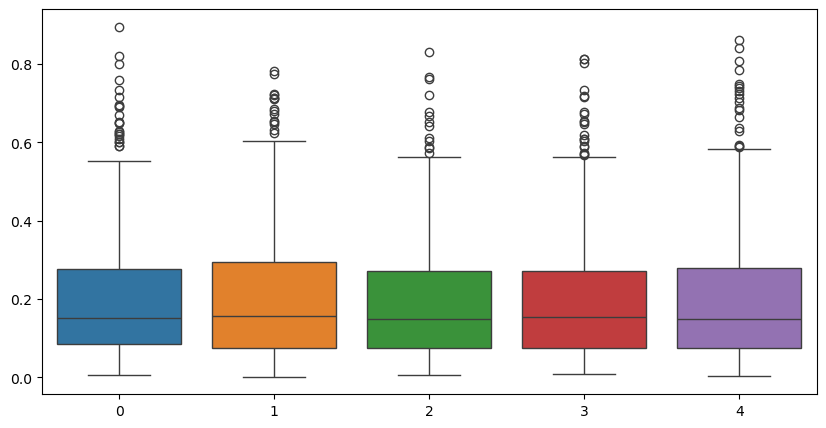

In [4]:
NUM_CONCEPTS_DIMS = 5
NUM_SAMPLES = NUM_CONCEPTS_DIMS*100
BATCH_SIZE = 32

torch.manual_seed(42)
sender_targets = torch.softmax(torch.randn(size = (NUM_SAMPLES, NUM_CONCEPTS_DIMS), device=DEVICE), dim = 1)

dataset = torch.utils.data.TensorDataset(sender_targets)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(data=sender_targets, ax=ax)

# 8.1

In [6]:
# LOAD

NUM_RUNS = 3

HIDDEN_SIZE = 32
NUM_LAYERS = 1
VOCAB_SIZE = 9
MAX_LEN = 5

EXPT_NAME = "exp8.1"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results = pickle.load(f)

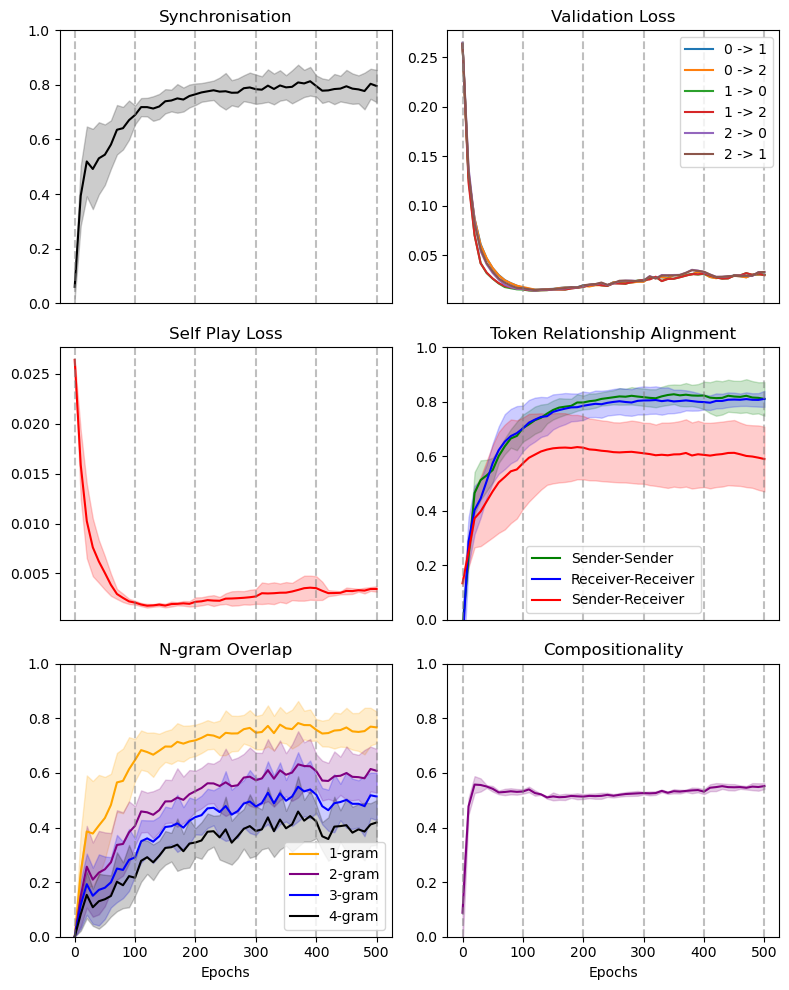

In [7]:
epoch_gap = 10
epochs = 500 + epoch_gap
epoch_line_period = 100

f, ax = plt.subplots(3, 2, figsize=(8, 10))

ax[0, 0].set_title("Synchronisation")
ax[0, 0].plot(np.arange(0, epochs, epoch_gap), 1-agg_val_results["edit_distance_mean"], label="Edit Distance", color = "black")
ax[0, 0].fill_between(np.arange(0, epochs, epoch_gap),
                        1-agg_val_results["edit_distance_mean"] - std_val_results["edit_distance_mean"], 
                        1-agg_val_results["edit_distance_mean"] + std_val_results["edit_distance_mean"], 
                        alpha=0.2, color = "black")
ax[0, 0].set_ylim(0,1)

# validation loss
for i, (k, v) in enumerate(agg_agents_val_lossEnfToEnd.items()):
    ax[0, 1].plot(np.arange(0, epochs, epoch_gap), v, label=f"{k[0]} -> {k[1]}")
ax[0, 1].legend()
ax[0, 1].set_title("Validation Loss")

ax[1, 0].set_title("Self Play Loss")
ax[1, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["self_intelligibility_mean"], label="Self Play Loss", color = "red")
ax[1, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["self_intelligibility_mean"] - std_val_results["self_intelligibility_mean"], 
                      agg_val_results["self_intelligibility_mean"] + std_val_results["self_intelligibility_mean"], 
                      alpha=0.2, color = "red")

ax[1, 1].set_title("Token Relationship Alignment")
ax[1, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["ss_correlations_mean"], label="Sender-Sender", color = 'green')
ax[1, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["rr_correlations_mean"], label="Receiver-Receiver", color = 'blue')
ax[1, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["sr_correlations_mean"], label="Sender-Receiver", color = 'red')
ax[1, 1].legend()
ax[1, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["ss_correlations_mean"] - std_val_results["ss_correlations_mean"], 
                      agg_val_results["ss_correlations_mean"] + std_val_results["ss_correlations_mean"], 
                      alpha=0.2, color = 'green')
ax[1, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["rr_correlations_mean"] - std_val_results["rr_correlations_mean"], 
                      agg_val_results["rr_correlations_mean"] + std_val_results["rr_correlations_mean"], 
                      alpha=0.2, color = 'blue')
ax[1, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["sr_correlations_mean"] - std_val_results["sr_correlations_mean"], 
                      agg_val_results["sr_correlations_mean"] + std_val_results["sr_correlations_mean"], 
                      alpha=0.2, color = 'red')
ax[1, 1].set_ylim(0, 1)

ax[2, 0].set_title("N-gram Overlap")
ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["1-gram_mean"], label="1-gram", color = 'orange')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                        agg_val_results["1-gram_mean"] - std_val_results["1-gram_mean"], 
                        agg_val_results["1-gram_mean"] + std_val_results["1-gram_mean"], 
                        alpha=0.2, color = 'orange')

ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["2-gram_mean"], label="2-gram", color = 'purple')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["2-gram_mean"] - std_val_results["2-gram_mean"], 
                      agg_val_results["2-gram_mean"] + std_val_results["2-gram_mean"], 
                      alpha=0.2, color = 'purple')

ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["3-gram_mean"], label="3-gram", color = 'blue')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["3-gram_mean"] - std_val_results["3-gram_mean"], 
                      agg_val_results["3-gram_mean"] + std_val_results["3-gram_mean"], 
                      alpha=0.2, color = 'blue')

ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["4-gram_mean"], label="4-gram", color = 'black')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["4-gram_mean"] - std_val_results["4-gram_mean"], 
                      agg_val_results["4-gram_mean"] + std_val_results["4-gram_mean"], 
                      alpha=0.2, color = 'black')
ax[2, 0].set_ylim(0, 1)
ax[2, 0].legend()

ax[2, 1].set_title("Compositionality")
ax[2, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["topological_similarity_mean"], label="Topological Similarity", color = "purple")
ax[2, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["topological_similarity_mean"] - std_val_results["topological_similarity_mean"], 
                      agg_val_results["topological_similarity_mean"] + std_val_results["topological_similarity_mean"], 
                      alpha=0.2, color = "purple")
ax[2, 1].set_ylim(0, 1)


for i in range(0, epochs, epoch_line_period):
    for j in range(3):
        ax[j, 0].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax[j, 1].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        if j!=2:
            ax[j, 0].set_xticks([])
            ax[j, 1].set_xticks([])

ax[2, 0].set_xlabel("Epochs")
ax[2, 1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()

In [8]:
# f.savefig('./FinalImages/FC-1.pdf') 

Text(0, 0.5, 'Loss')

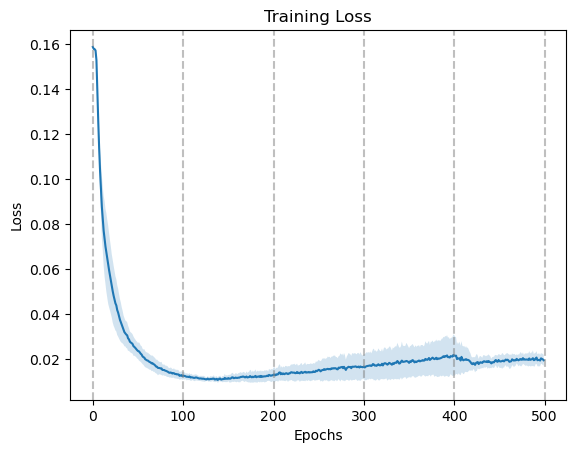

In [9]:
epoch_gap = 10
epochs = 500 + epoch_gap
epoch_line_period = 100

f, ax = plt.subplots()
ax.set_title("Training Loss")
ax.plot(agg_epoch_losses)
ax.fill_between(np.arange(0, epochs-epoch_gap, 1),
                        agg_epoch_losses - std_epoch_losses, 
                        agg_epoch_losses + std_epoch_losses, 
                        alpha=0.2)
for i in range(0, epochs, epoch_line_period):
    ax.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [10]:
# f.savefig('./FinalImages/FC-training.pdf') 

# 8.2 Competition

In [11]:
# Load results from 8.1, and compare with 8.2 using plots

NUM_RUNS = 3
HIDDEN_SIZE = 32
NUM_LAYERS = 1
VOCAB_SIZE = 9

EXPT_NAME = "exp8.1"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_1 = pickle.load(f)

EXPT_NAME = "exp8.2"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_2 = pickle.load(f)


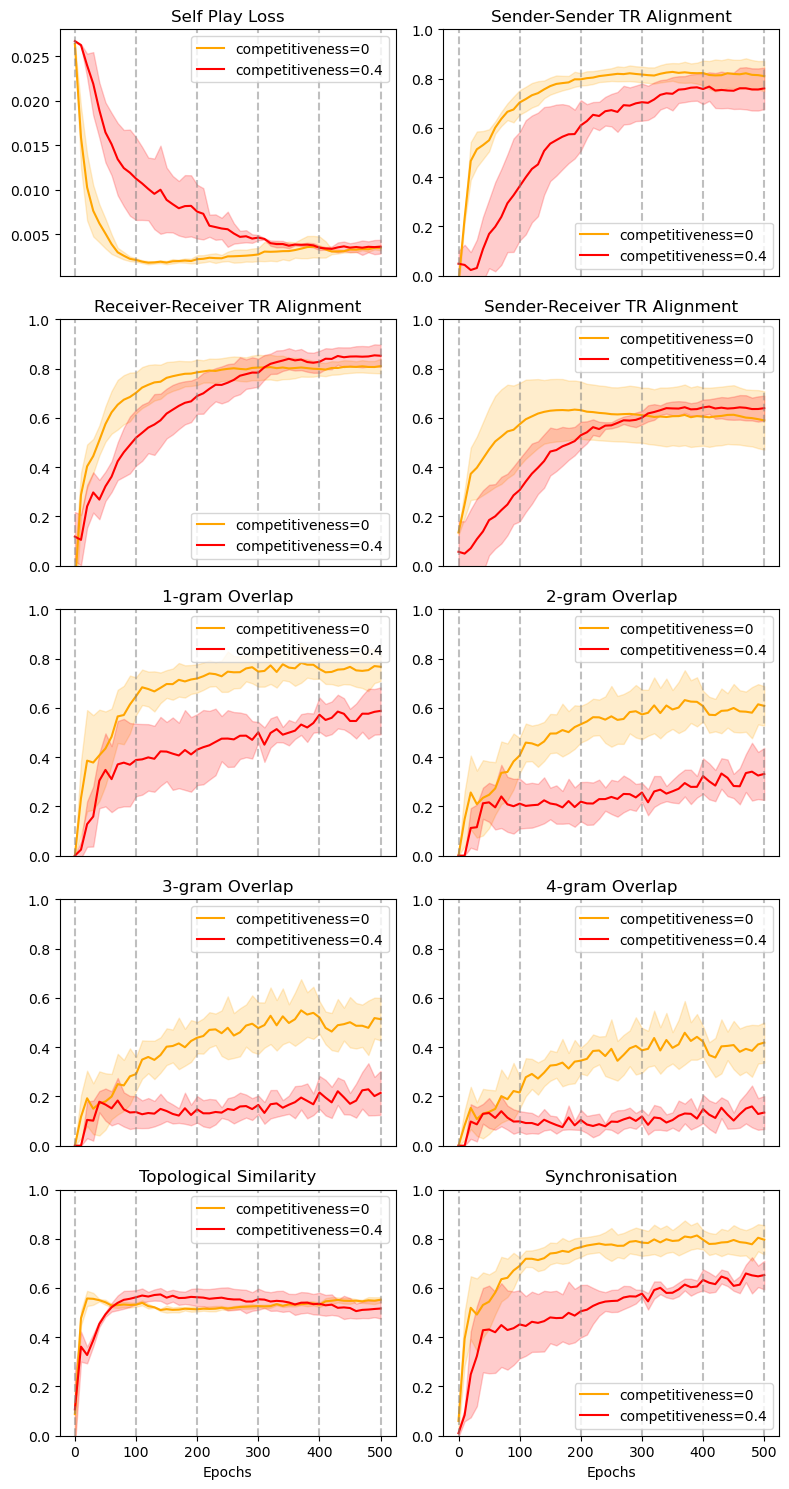

In [12]:
epochs_1 = 500+10
epochs_2 = 500+10
epoch_gap = 10
epoch_line_period = 100

f, ax = plt.subplots(5, 2, figsize=(8, 15))

ax[0, 0].set_title("Self Play Loss")
ax[0, 0].plot(np.arange(0, epochs_1, epoch_gap), agg_val_results_1["self_intelligibility_mean"], label="competitiveness=0", color = "orange")
ax[0, 0].fill_between(np.arange(0, epochs_1, epoch_gap),
                      agg_val_results_1["self_intelligibility_mean"] - std_val_results_1["self_intelligibility_mean"],
                      agg_val_results_1["self_intelligibility_mean"] + std_val_results_1["self_intelligibility_mean"],
                      alpha=0.2, color = "orange")
ax[0, 0].plot(np.arange(0, epochs_2, epoch_gap), agg_val_results_2["self_intelligibility_mean"], label="competitiveness=0.4", color = "red")
ax[0, 0].fill_between(np.arange(0, epochs_2, epoch_gap),
                      agg_val_results_2["self_intelligibility_mean"] - std_val_results_2["self_intelligibility_mean"],
                      agg_val_results_2["self_intelligibility_mean"] + std_val_results_2["self_intelligibility_mean"],
                      alpha=0.2, color = "red")
ax[0, 0].legend()

ax[0, 1].set_title("Sender-Sender TR Alignment")
ax[0, 1].plot(np.arange(0, epochs_1, epoch_gap), agg_val_results_1["ss_correlations_mean"], label="competitiveness=0", color = 'orange')
ax[0, 1].fill_between(np.arange(0, epochs_1, epoch_gap),
                        agg_val_results_1["ss_correlations_mean"] - std_val_results_1["ss_correlations_mean"],
                        agg_val_results_1["ss_correlations_mean"] + std_val_results_1["ss_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[0, 1].plot(np.arange(0, epochs_2, epoch_gap), agg_val_results_2["ss_correlations_mean"], label="competitiveness=0.4", color = 'red')
ax[0, 1].fill_between(np.arange(0, epochs_2, epoch_gap),
                        agg_val_results_2["ss_correlations_mean"] - std_val_results_2["ss_correlations_mean"],
                        agg_val_results_2["ss_correlations_mean"] + std_val_results_2["ss_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[0, 1].legend()
ax[0, 1].set_ylim(0, 1)

ax[1, 0].set_title("Receiver-Receiver TR Alignment")
ax[1, 0].plot(np.arange(0, epochs_1, epoch_gap), agg_val_results_1["rr_correlations_mean"], label="competitiveness=0", color = 'orange')
ax[1, 0].fill_between(np.arange(0, epochs_1, epoch_gap),
                        agg_val_results_1["rr_correlations_mean"] - std_val_results_1["rr_correlations_mean"],
                        agg_val_results_1["rr_correlations_mean"] + std_val_results_1["rr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 0].plot(np.arange(0, epochs_2, epoch_gap), agg_val_results_2["rr_correlations_mean"], label="competitiveness=0.4", color = 'red')
ax[1, 0].fill_between(np.arange(0, epochs_2, epoch_gap),
                        agg_val_results_2["rr_correlations_mean"] - std_val_results_2["rr_correlations_mean"],
                        agg_val_results_2["rr_correlations_mean"] + std_val_results_2["rr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 0].legend()
ax[1, 0].set_ylim(0, 1)

ax[1, 1].set_title("Sender-Receiver TR Alignment")
ax[1, 1].plot(np.arange(0, epochs_1, epoch_gap), agg_val_results_1["sr_correlations_mean"], label="competitiveness=0", color = 'orange')
ax[1, 1].fill_between(np.arange(0, epochs_1, epoch_gap),
                        agg_val_results_1["sr_correlations_mean"] - std_val_results_1["sr_correlations_mean"],
                        agg_val_results_1["sr_correlations_mean"] + std_val_results_1["sr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 1].plot(np.arange(0, epochs_2, epoch_gap), agg_val_results_2["sr_correlations_mean"], label="competitiveness=0.4", color = 'red')
ax[1, 1].fill_between(np.arange(0, epochs_2, epoch_gap),
                        agg_val_results_2["sr_correlations_mean"] - std_val_results_2["sr_correlations_mean"],
                        agg_val_results_2["sr_correlations_mean"] + std_val_results_2["sr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 1].legend()
ax[1, 1].set_ylim(0, 1)


ax[2, 0].set_title("1-gram Overlap")
ax[2, 0].plot(np.arange(0, epochs_1, epoch_gap), agg_val_results_1["1-gram_mean"], label="competitiveness=0", color = 'orange')
ax[2, 0].fill_between(np.arange(0, epochs_1, epoch_gap),
                        agg_val_results_1["1-gram_mean"] - std_val_results_1["1-gram_mean"],
                        agg_val_results_1["1-gram_mean"] + std_val_results_1["1-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 0].plot(np.arange(0, epochs_2, epoch_gap), agg_val_results_2["1-gram_mean"], label="competitiveness=0.4", color = 'red')
ax[2, 0].fill_between(np.arange(0, epochs_2, epoch_gap),
                        agg_val_results_2["1-gram_mean"] - std_val_results_2["1-gram_mean"],
                        agg_val_results_2["1-gram_mean"] + std_val_results_2["1-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 0].legend()
ax[2, 0].set_ylim(0, 1)

ax[2, 1].set_title("2-gram Overlap")
ax[2, 1].plot(np.arange(0, epochs_1, epoch_gap), agg_val_results_1["2-gram_mean"], label="competitiveness=0", color = 'orange')
ax[2, 1].fill_between(np.arange(0, epochs_1, epoch_gap),
                        agg_val_results_1["2-gram_mean"] - std_val_results_1["2-gram_mean"],
                        agg_val_results_1["2-gram_mean"] + std_val_results_1["2-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 1].plot(np.arange(0, epochs_2, epoch_gap), agg_val_results_2["2-gram_mean"], label="competitiveness=0.4", color = 'red')
ax[2, 1].fill_between(np.arange(0, epochs_2, epoch_gap),
                        agg_val_results_2["2-gram_mean"] - std_val_results_2["2-gram_mean"],
                        agg_val_results_2["2-gram_mean"] + std_val_results_2["2-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 1].legend()
ax[2, 1].set_ylim(0, 1)

ax[3, 0].set_title("3-gram Overlap")
ax[3, 0].plot(np.arange(0, epochs_1, epoch_gap), agg_val_results_1["3-gram_mean"], label="competitiveness=0", color = 'orange')
ax[3, 0].fill_between(np.arange(0, epochs_1, epoch_gap),
                        agg_val_results_1["3-gram_mean"] - std_val_results_1["3-gram_mean"],
                        agg_val_results_1["3-gram_mean"] + std_val_results_1["3-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 0].plot(np.arange(0, epochs_2, epoch_gap), agg_val_results_2["3-gram_mean"], label="competitiveness=0.4", color = 'red')
ax[3, 0].fill_between(np.arange(0, epochs_2, epoch_gap),
                        agg_val_results_2["3-gram_mean"] - std_val_results_2["3-gram_mean"],
                        agg_val_results_2["3-gram_mean"] + std_val_results_2["3-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 0].legend()
ax[3, 0].set_ylim(0, 1)

ax[3, 1].set_title("4-gram Overlap")
ax[3, 1].plot(np.arange(0, epochs_1, epoch_gap), agg_val_results_1["4-gram_mean"], label="competitiveness=0", color = 'orange')
ax[3, 1].fill_between(np.arange(0, epochs_1, epoch_gap),
                        agg_val_results_1["4-gram_mean"] - std_val_results_1["4-gram_mean"],
                        agg_val_results_1["4-gram_mean"] + std_val_results_1["4-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 1].plot(np.arange(0, epochs_2, epoch_gap), agg_val_results_2["4-gram_mean"], label="competitiveness=0.4", color = 'red')
ax[3, 1].fill_between(np.arange(0, epochs_2, epoch_gap),
                        agg_val_results_2["4-gram_mean"] - std_val_results_2["4-gram_mean"],
                        agg_val_results_2["4-gram_mean"] + std_val_results_2["4-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 1].legend()
ax[3, 1].set_ylim(0, 1)

ax[4, 0].set_title("Topological Similarity")
ax[4, 0].plot(np.arange(0, epochs_1, epoch_gap), agg_val_results_1["topological_similarity_mean"], label="competitiveness=0", color = "orange")
ax[4, 0].fill_between(np.arange(0, epochs_1, epoch_gap),
                        agg_val_results_1["topological_similarity_mean"] - std_val_results_1["topological_similarity_mean"],
                        agg_val_results_1["topological_similarity_mean"] + std_val_results_1["topological_similarity_mean"],
                        alpha=0.2, color = "orange")
ax[4, 0].plot(np.arange(0, epochs_2, epoch_gap), agg_val_results_2["topological_similarity_mean"], label="competitiveness=0.4", color = "red")
ax[4, 0].fill_between(np.arange(0, epochs_2, epoch_gap),  
                        agg_val_results_2["topological_similarity_mean"] - std_val_results_2["topological_similarity_mean"],
                        agg_val_results_2["topological_similarity_mean"] + std_val_results_2["topological_similarity_mean"],
                        alpha=0.2, color = "red")
ax[4, 0].legend()
ax[4, 0].set_ylim(0, 1)

ax[4, 1].set_title("Synchronisation")
ax[4, 1].plot(np.arange(0, epochs_1, epoch_gap), 1-agg_val_results_1["edit_distance_mean"], label="competitiveness=0", color = "orange")
ax[4, 1].fill_between(np.arange(0, epochs_1, epoch_gap),
                        (1-agg_val_results_1["edit_distance_mean"]) - std_val_results_1["edit_distance_mean"],
                        (1-agg_val_results_1["edit_distance_mean"]) + std_val_results_1["edit_distance_mean"],
                        alpha=0.2, color = "orange")
ax[4, 1].plot(np.arange(0, epochs_2, epoch_gap), 1-agg_val_results_2["edit_distance_mean"], label="competitiveness=0.4", color = "red")
ax[4, 1].fill_between(np.arange(0, epochs_2, epoch_gap),
                        1-agg_val_results_2["edit_distance_mean"] - std_val_results_2["edit_distance_mean"],
                        1-agg_val_results_2["edit_distance_mean"] + std_val_results_2["edit_distance_mean"],
                        alpha=0.2, color = "red")
ax[4, 1].legend()
ax[4, 1].set_ylim(0, 1)

ax[4, 0].set_xlabel("Epochs")
ax[4, 1].set_xlabel("Epochs")


for i in range(0, epochs_2, epoch_line_period):
    for j in range(5):
        ax[j, 0].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax[j, 1].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        if j!=4:
            ax[j, 0].set_xticks([])
            ax[j, 1].set_xticks([])

plt.tight_layout()
plt.show()

In [13]:
# f.savefig('./FinalImages/FC-comp.pdf')

# Increasing Max Sequence Length

In [14]:
# Load results from 8.1, and compare with 8.2 using plots

NUM_RUNS = 3
HIDDEN_SIZE = 32
NUM_LAYERS = 1
VOCAB_SIZE = 9

EXPT_NAME = "exp8.1"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_1 = pickle.load(f)

EXPT_NAME = "exp8.6"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_2 = pickle.load(f)


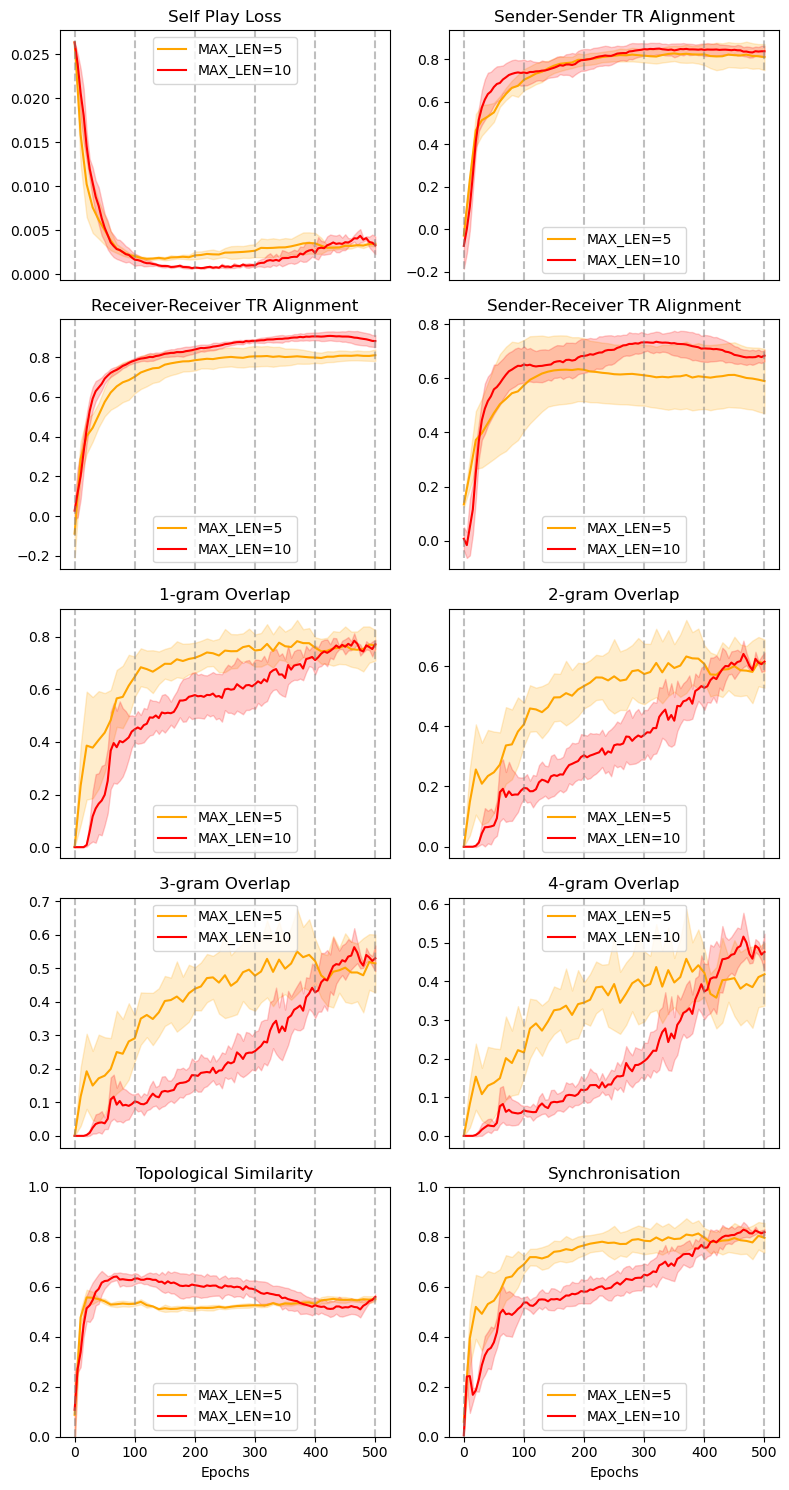

In [15]:
epoch_gap_1 = 10
epoch_gap_2 = 5

epochs_1 = 500+epoch_gap_1
epochs_2 = 500+epoch_gap_2

label_1 = "MAX_LEN=5"
label_2 = "MAX_LEN=10"

epoch_line_period = 100

f, ax = plt.subplots(5, 2, figsize=(8, 15))

ax[0, 0].set_title("Self Play Loss")
ax[0, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["self_intelligibility_mean"], label=label_1, color = "orange")
ax[0, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                      agg_val_results_1["self_intelligibility_mean"] - std_val_results_1["self_intelligibility_mean"],
                      agg_val_results_1["self_intelligibility_mean"] + std_val_results_1["self_intelligibility_mean"],
                      alpha=0.2, color = "orange")
ax[0, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["self_intelligibility_mean"], label=label_2, color = "red")
ax[0, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                      agg_val_results_2["self_intelligibility_mean"] - std_val_results_2["self_intelligibility_mean"],
                      agg_val_results_2["self_intelligibility_mean"] + std_val_results_2["self_intelligibility_mean"],
                      alpha=0.2, color = "red")
ax[0, 0].legend()

ax[0, 1].set_title("Sender-Sender TR Alignment")
ax[0, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["ss_correlations_mean"], label=label_1, color = 'orange')
ax[0, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["ss_correlations_mean"] - std_val_results_1["ss_correlations_mean"],
                        agg_val_results_1["ss_correlations_mean"] + std_val_results_1["ss_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[0, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["ss_correlations_mean"], label=label_2, color = 'red')
ax[0, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["ss_correlations_mean"] - std_val_results_2["ss_correlations_mean"],
                        agg_val_results_2["ss_correlations_mean"] + std_val_results_2["ss_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[0, 1].legend()

ax[1, 0].set_title("Receiver-Receiver TR Alignment")
ax[1, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["rr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["rr_correlations_mean"] - std_val_results_1["rr_correlations_mean"],
                        agg_val_results_1["rr_correlations_mean"] + std_val_results_1["rr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["rr_correlations_mean"], label=label_2, color = 'red')

ax[1, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["rr_correlations_mean"] - std_val_results_2["rr_correlations_mean"],
                        agg_val_results_2["rr_correlations_mean"] + std_val_results_2["rr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 0].legend()

ax[1, 1].set_title("Sender-Receiver TR Alignment")
ax[1, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["sr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["sr_correlations_mean"] - std_val_results_1["sr_correlations_mean"],
                        agg_val_results_1["sr_correlations_mean"] + std_val_results_1["sr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["sr_correlations_mean"], label=label_2, color = 'red')
ax[1, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["sr_correlations_mean"] - std_val_results_2["sr_correlations_mean"],
                        agg_val_results_2["sr_correlations_mean"] + std_val_results_2["sr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 1].legend()

ax[2, 0].set_title("1-gram Overlap")
ax[2, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["1-gram_mean"], label=label_1, color = 'orange')
ax[2, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["1-gram_mean"] - std_val_results_1["1-gram_mean"],
                        agg_val_results_1["1-gram_mean"] + std_val_results_1["1-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["1-gram_mean"], label=label_2, color = 'red')
ax[2, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["1-gram_mean"] - std_val_results_2["1-gram_mean"],
                        agg_val_results_2["1-gram_mean"] + std_val_results_2["1-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 0].legend()

ax[2, 1].set_title("2-gram Overlap")
ax[2, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["2-gram_mean"], label=label_1, color = 'orange')
ax[2, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["2-gram_mean"] - std_val_results_1["2-gram_mean"],
                        agg_val_results_1["2-gram_mean"] + std_val_results_1["2-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["2-gram_mean"], label=label_2, color = 'red')
ax[2, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["2-gram_mean"] - std_val_results_2["2-gram_mean"],
                        agg_val_results_2["2-gram_mean"] + std_val_results_2["2-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 1].legend()

ax[3, 0].set_title("3-gram Overlap")
ax[3, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["3-gram_mean"], label=label_1, color = 'orange')
ax[3, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["3-gram_mean"] - std_val_results_1["3-gram_mean"],
                        agg_val_results_1["3-gram_mean"] + std_val_results_1["3-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["3-gram_mean"], label=label_2, color = 'red')
ax[3, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["3-gram_mean"] - std_val_results_2["3-gram_mean"],
                        agg_val_results_2["3-gram_mean"] + std_val_results_2["3-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 0].legend()

ax[3, 1].set_title("4-gram Overlap")
ax[3, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["4-gram_mean"], label=label_1, color = 'orange')
ax[3, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["4-gram_mean"] - std_val_results_1["4-gram_mean"],
                        agg_val_results_1["4-gram_mean"] + std_val_results_1["4-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["4-gram_mean"], label=label_2, color = 'red')
ax[3, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["4-gram_mean"] - std_val_results_2["4-gram_mean"],
                        agg_val_results_2["4-gram_mean"] + std_val_results_2["4-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 1].legend()

ax[4, 0].set_title("Topological Similarity")
ax[4, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["topological_similarity_mean"], label=label_1, color = "orange")
ax[4, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["topological_similarity_mean"] - std_val_results_1["topological_similarity_mean"],
                        agg_val_results_1["topological_similarity_mean"] + std_val_results_1["topological_similarity_mean"],
                        alpha=0.2, color = "orange")
ax[4, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["topological_similarity_mean"], label=label_2, color = "red")
ax[4, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["topological_similarity_mean"] - std_val_results_2["topological_similarity_mean"],
                        agg_val_results_2["topological_similarity_mean"] + std_val_results_2["topological_similarity_mean"],
                        alpha=0.2, color = "red")
ax[4, 0].legend()
ax[4, 0].set_ylim(0, 1)

ax[4, 1].set_title("Synchronisation")
ax[4, 1].plot(np.arange(0, epochs_1, epoch_gap_1), 1-agg_val_results_1["edit_distance_mean"], label=label_1, color = "orange")
ax[4, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        (1-agg_val_results_1["edit_distance_mean"]) - std_val_results_1["edit_distance_mean"],
                        (1-agg_val_results_1["edit_distance_mean"]) + std_val_results_1["edit_distance_mean"],
                        alpha=0.2, color = "orange")
ax[4, 1].plot(np.arange(0, epochs_2, epoch_gap_2), 1-agg_val_results_2["edit_distance_mean"], label=label_2, color = "red")
ax[4, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        1-agg_val_results_2["edit_distance_mean"] - std_val_results_2["edit_distance_mean"],
                        1-agg_val_results_2["edit_distance_mean"] + std_val_results_2["edit_distance_mean"],
                        alpha=0.2, color = "red")
ax[4, 1].legend()
ax[4, 1].set_ylim(0, 1)

ax[4, 0].set_xlabel("Epochs")
ax[4, 1].set_xlabel("Epochs")

for i in range(0, epochs_2, epoch_line_period):
    for j in range(5):
        ax[j, 0].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax[j, 1].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        if j!=4:
            ax[j, 0].set_xticks([])
            ax[j, 1].set_xticks([])

plt.tight_layout()
plt.show()

In [16]:
# f.savefig('./FinalImages/FC-max-len.pdf')

# Ring

In [17]:
# Load results from 8.1, and compare with 8.2 using plots

NUM_RUNS = 3
HIDDEN_SIZE = 32
NUM_LAYERS = 1
VOCAB_SIZE = 9

EXPT_NAME = "exp8.1"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_1 = pickle.load(f)

EXPT_NAME = "exp8.4"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_2 = pickle.load(f)


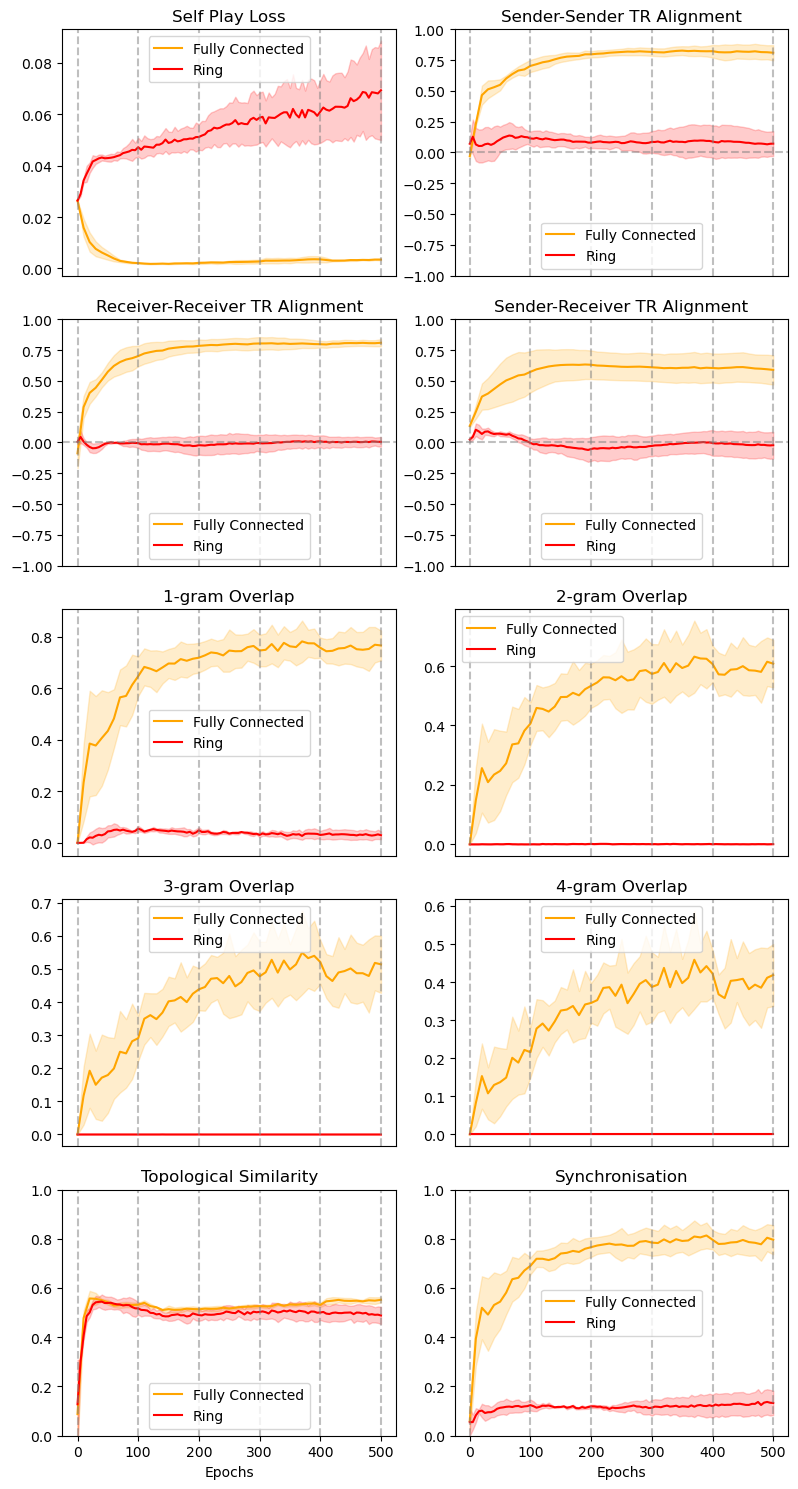

In [18]:
epoch_gap_1 = 10
epoch_gap_2 = 5

epochs_1 = 500+epoch_gap_1
epochs_2 = 500+epoch_gap_2

label_1 = "Fully Connected"
label_2 = "Ring"

epoch_line_period = 100

f, ax = plt.subplots(5, 2, figsize=(8, 15))

ax[0, 0].set_title("Self Play Loss")
ax[0, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["self_intelligibility_mean"], label=label_1, color = "orange")
ax[0, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                      agg_val_results_1["self_intelligibility_mean"] - std_val_results_1["self_intelligibility_mean"],
                      agg_val_results_1["self_intelligibility_mean"] + std_val_results_1["self_intelligibility_mean"],
                      alpha=0.2, color = "orange")
ax[0, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["self_intelligibility_mean"], label=label_2, color = "red")
ax[0, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                      agg_val_results_2["self_intelligibility_mean"] - std_val_results_2["self_intelligibility_mean"],
                      agg_val_results_2["self_intelligibility_mean"] + std_val_results_2["self_intelligibility_mean"],
                      alpha=0.2, color = "red")
ax[0, 0].legend()

ax[0, 1].set_title("Sender-Sender TR Alignment")
ax[0, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["ss_correlations_mean"], label=label_1, color = 'orange')
ax[0, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["ss_correlations_mean"] - std_val_results_1["ss_correlations_mean"],
                        agg_val_results_1["ss_correlations_mean"] + std_val_results_1["ss_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[0, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["ss_correlations_mean"], label=label_2, color = 'red')
ax[0, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["ss_correlations_mean"] - std_val_results_2["ss_correlations_mean"],
                        agg_val_results_2["ss_correlations_mean"] + std_val_results_2["ss_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[0, 1].legend()
ax[0, 1].set_ylim(-1, 1)
ax[0, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[1, 0].set_title("Receiver-Receiver TR Alignment")
ax[1, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["rr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["rr_correlations_mean"] - std_val_results_1["rr_correlations_mean"],
                        agg_val_results_1["rr_correlations_mean"] + std_val_results_1["rr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["rr_correlations_mean"], label=label_2, color = 'red')

ax[1, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["rr_correlations_mean"] - std_val_results_2["rr_correlations_mean"],
                        agg_val_results_2["rr_correlations_mean"] + std_val_results_2["rr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 0].legend()
ax[1, 0].set_ylim(-1, 1)
ax[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[1, 1].set_title("Sender-Receiver TR Alignment")
ax[1, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["sr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["sr_correlations_mean"] - std_val_results_1["sr_correlations_mean"],
                        agg_val_results_1["sr_correlations_mean"] + std_val_results_1["sr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["sr_correlations_mean"], label=label_2, color = 'red')
ax[1, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["sr_correlations_mean"] - std_val_results_2["sr_correlations_mean"],
                        agg_val_results_2["sr_correlations_mean"] + std_val_results_2["sr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 1].legend()
ax[1, 1].set_ylim(-1, 1)
ax[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[2, 0].set_title("1-gram Overlap")
ax[2, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["1-gram_mean"], label=label_1, color = 'orange')
ax[2, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["1-gram_mean"] - std_val_results_1["1-gram_mean"],
                        agg_val_results_1["1-gram_mean"] + std_val_results_1["1-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["1-gram_mean"], label=label_2, color = 'red')
ax[2, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["1-gram_mean"] - std_val_results_2["1-gram_mean"],
                        agg_val_results_2["1-gram_mean"] + std_val_results_2["1-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 0].legend()

ax[2, 1].set_title("2-gram Overlap")
ax[2, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["2-gram_mean"], label=label_1, color = 'orange')
ax[2, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["2-gram_mean"] - std_val_results_1["2-gram_mean"],
                        agg_val_results_1["2-gram_mean"] + std_val_results_1["2-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["2-gram_mean"], label=label_2, color = 'red')
ax[2, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["2-gram_mean"] - std_val_results_2["2-gram_mean"],
                        agg_val_results_2["2-gram_mean"] + std_val_results_2["2-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 1].legend()

ax[3, 0].set_title("3-gram Overlap")
ax[3, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["3-gram_mean"], label=label_1, color = 'orange')
ax[3, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["3-gram_mean"] - std_val_results_1["3-gram_mean"],
                        agg_val_results_1["3-gram_mean"] + std_val_results_1["3-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["3-gram_mean"], label=label_2, color = 'red')
ax[3, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["3-gram_mean"] - std_val_results_2["3-gram_mean"],
                        agg_val_results_2["3-gram_mean"] + std_val_results_2["3-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 0].legend()

ax[3, 1].set_title("4-gram Overlap")
ax[3, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["4-gram_mean"], label=label_1, color = 'orange')
ax[3, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["4-gram_mean"] - std_val_results_1["4-gram_mean"],
                        agg_val_results_1["4-gram_mean"] + std_val_results_1["4-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["4-gram_mean"], label=label_2, color = 'red')
ax[3, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["4-gram_mean"] - std_val_results_2["4-gram_mean"],
                        agg_val_results_2["4-gram_mean"] + std_val_results_2["4-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 1].legend()

ax[4, 0].set_title("Topological Similarity")
ax[4, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["topological_similarity_mean"], label=label_1, color = "orange")
ax[4, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["topological_similarity_mean"] - std_val_results_1["topological_similarity_mean"],
                        agg_val_results_1["topological_similarity_mean"] + std_val_results_1["topological_similarity_mean"],
                        alpha=0.2, color = "orange")
ax[4, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["topological_similarity_mean"], label=label_2, color = "red")
ax[4, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["topological_similarity_mean"] - std_val_results_2["topological_similarity_mean"],
                        agg_val_results_2["topological_similarity_mean"] + std_val_results_2["topological_similarity_mean"],
                        alpha=0.2, color = "red")
ax[4, 0].legend()
ax[4, 0].set_ylim(0, 1)

ax[4, 1].set_title("Synchronisation")
ax[4, 1].plot(np.arange(0, epochs_1, epoch_gap_1), 1-agg_val_results_1["edit_distance_mean"], label=label_1, color = "orange")
ax[4, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        (1-agg_val_results_1["edit_distance_mean"]) - std_val_results_1["edit_distance_mean"],
                        (1-agg_val_results_1["edit_distance_mean"]) + std_val_results_1["edit_distance_mean"],
                        alpha=0.2, color = "orange")
ax[4, 1].plot(np.arange(0, epochs_2, epoch_gap_2), 1-agg_val_results_2["edit_distance_mean"], label=label_2, color = "red")
ax[4, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        1-agg_val_results_2["edit_distance_mean"] - std_val_results_2["edit_distance_mean"],
                        1-agg_val_results_2["edit_distance_mean"] + std_val_results_2["edit_distance_mean"],
                        alpha=0.2, color = "red")
ax[4, 1].legend()
ax[4, 1].set_ylim(0, 1)

ax[4, 0].set_xlabel("Epochs")
ax[4, 1].set_xlabel("Epochs")

for i in range(0, epochs_2, epoch_line_period):
    for j in range(5):
        ax[j, 0].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax[j, 1].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        if j!=4:
            ax[j, 0].set_xticks([])
            ax[j, 1].set_xticks([])

plt.tight_layout()
plt.show()

In [19]:
# f.savefig('./FinalImages/FC-ring-no-inner-speech.pdf')

# 8.7 IC with 3 Agents

In [20]:
NUM_RUNS = 3
HIDDEN_SIZE = 32
NUM_LAYERS = 1
VOCAB_SIZE = 9

EXPT_NAME = "exp8.1"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_1 = pickle.load(f)

EXPT_NAME = "exp8.7"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_2 = pickle.load(f)


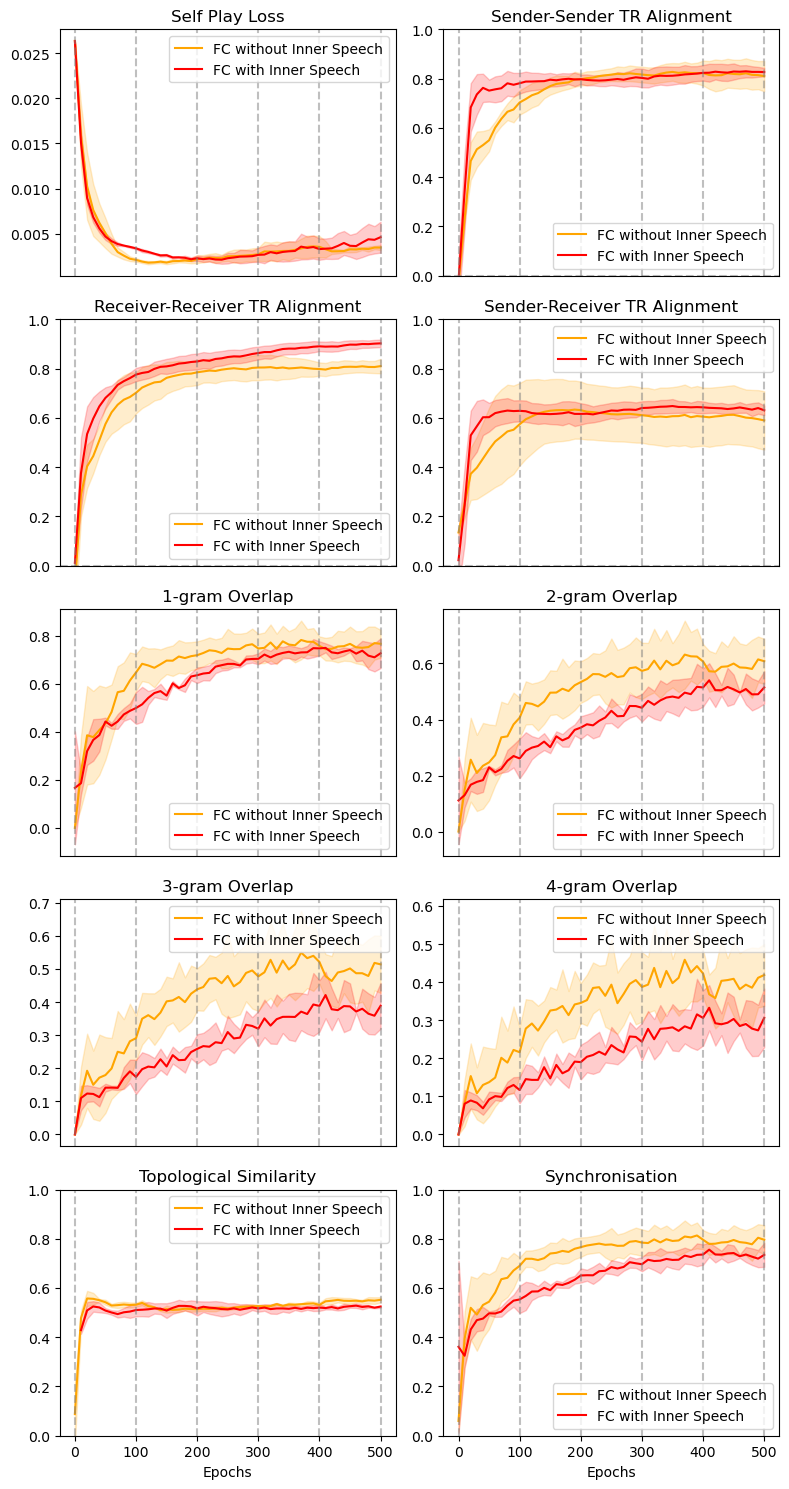

In [21]:
epoch_gap_1 = 10
epoch_gap_2 = 10

epochs_1 = 500+epoch_gap_1
epochs_2 = 500+epoch_gap_2

label_1 = "FC without Inner Speech"
label_2 = "FC with Inner Speech"

epoch_line_period = 100

f, ax = plt.subplots(5, 2, figsize=(8, 15))

ax[0, 0].set_title("Self Play Loss")
ax[0, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["self_intelligibility_mean"], label=label_1, color = "orange")
ax[0, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                      agg_val_results_1["self_intelligibility_mean"] - std_val_results_1["self_intelligibility_mean"],
                      agg_val_results_1["self_intelligibility_mean"] + std_val_results_1["self_intelligibility_mean"],
                      alpha=0.2, color = "orange")
ax[0, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["self_intelligibility_mean"], label=label_2, color = "red")
ax[0, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                      agg_val_results_2["self_intelligibility_mean"] - std_val_results_2["self_intelligibility_mean"],
                      agg_val_results_2["self_intelligibility_mean"] + std_val_results_2["self_intelligibility_mean"],
                      alpha=0.2, color = "red")
ax[0, 0].legend()

ax[0, 1].set_title("Sender-Sender TR Alignment")
ax[0, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["ss_correlations_mean"], label=label_1, color = 'orange')
ax[0, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["ss_correlations_mean"] - std_val_results_1["ss_correlations_mean"],
                        agg_val_results_1["ss_correlations_mean"] + std_val_results_1["ss_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[0, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["ss_correlations_mean"], label=label_2, color = 'red')
ax[0, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["ss_correlations_mean"] - std_val_results_2["ss_correlations_mean"],
                        agg_val_results_2["ss_correlations_mean"] + std_val_results_2["ss_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[0, 1].legend()
ax[0, 1].set_ylim(0, 1)
ax[0, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[1, 0].set_title("Receiver-Receiver TR Alignment")
ax[1, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["rr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["rr_correlations_mean"] - std_val_results_1["rr_correlations_mean"],
                        agg_val_results_1["rr_correlations_mean"] + std_val_results_1["rr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["rr_correlations_mean"], label=label_2, color = 'red')

ax[1, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["rr_correlations_mean"] - std_val_results_2["rr_correlations_mean"],
                        agg_val_results_2["rr_correlations_mean"] + std_val_results_2["rr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 0].legend()
ax[1, 0].set_ylim(0, 1)
ax[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[1, 1].set_title("Sender-Receiver TR Alignment")
ax[1, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["sr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["sr_correlations_mean"] - std_val_results_1["sr_correlations_mean"],
                        agg_val_results_1["sr_correlations_mean"] + std_val_results_1["sr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["sr_correlations_mean"], label=label_2, color = 'red')
ax[1, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["sr_correlations_mean"] - std_val_results_2["sr_correlations_mean"],
                        agg_val_results_2["sr_correlations_mean"] + std_val_results_2["sr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 1].legend()
ax[1, 1].set_ylim(0, 1)
ax[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[2, 0].set_title("1-gram Overlap")
ax[2, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["1-gram_mean"], label=label_1, color = 'orange')
ax[2, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["1-gram_mean"] - std_val_results_1["1-gram_mean"],
                        agg_val_results_1["1-gram_mean"] + std_val_results_1["1-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["1-gram_mean"], label=label_2, color = 'red')
ax[2, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["1-gram_mean"] - std_val_results_2["1-gram_mean"],
                        agg_val_results_2["1-gram_mean"] + std_val_results_2["1-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 0].legend()

ax[2, 1].set_title("2-gram Overlap")
ax[2, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["2-gram_mean"], label=label_1, color = 'orange')
ax[2, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["2-gram_mean"] - std_val_results_1["2-gram_mean"],
                        agg_val_results_1["2-gram_mean"] + std_val_results_1["2-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["2-gram_mean"], label=label_2, color = 'red')
ax[2, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["2-gram_mean"] - std_val_results_2["2-gram_mean"],
                        agg_val_results_2["2-gram_mean"] + std_val_results_2["2-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 1].legend()

ax[3, 0].set_title("3-gram Overlap")
ax[3, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["3-gram_mean"], label=label_1, color = 'orange')
ax[3, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["3-gram_mean"] - std_val_results_1["3-gram_mean"],
                        agg_val_results_1["3-gram_mean"] + std_val_results_1["3-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["3-gram_mean"], label=label_2, color = 'red')
ax[3, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["3-gram_mean"] - std_val_results_2["3-gram_mean"],
                        agg_val_results_2["3-gram_mean"] + std_val_results_2["3-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 0].legend()

ax[3, 1].set_title("4-gram Overlap")
ax[3, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["4-gram_mean"], label=label_1, color = 'orange')
ax[3, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["4-gram_mean"] - std_val_results_1["4-gram_mean"],
                        agg_val_results_1["4-gram_mean"] + std_val_results_1["4-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["4-gram_mean"], label=label_2, color = 'red')
ax[3, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["4-gram_mean"] - std_val_results_2["4-gram_mean"],
                        agg_val_results_2["4-gram_mean"] + std_val_results_2["4-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 1].legend()

ax[4, 0].set_title("Topological Similarity")
ax[4, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["topological_similarity_mean"], label=label_1, color = "orange")
ax[4, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["topological_similarity_mean"] - std_val_results_1["topological_similarity_mean"],
                        agg_val_results_1["topological_similarity_mean"] + std_val_results_1["topological_similarity_mean"],
                        alpha=0.2, color = "orange")
ax[4, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["topological_similarity_mean"], label=label_2, color = "red")
ax[4, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["topological_similarity_mean"] - std_val_results_2["topological_similarity_mean"],
                        agg_val_results_2["topological_similarity_mean"] + std_val_results_2["topological_similarity_mean"],
                        alpha=0.2, color = "red")
ax[4, 0].legend()
ax[4, 0].set_ylim(0, 1)

ax[4, 1].set_title("Synchronisation")
ax[4, 1].plot(np.arange(0, epochs_1, epoch_gap_1), 1-agg_val_results_1["edit_distance_mean"], label=label_1, color = "orange")
ax[4, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        (1-agg_val_results_1["edit_distance_mean"]) - std_val_results_1["edit_distance_mean"],
                        (1-agg_val_results_1["edit_distance_mean"]) + std_val_results_1["edit_distance_mean"],
                        alpha=0.2, color = "orange")
ax[4, 1].plot(np.arange(0, epochs_2, epoch_gap_2), 1-agg_val_results_2["edit_distance_mean"], label=label_2, color = "red")
ax[4, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        1-agg_val_results_2["edit_distance_mean"] - std_val_results_2["edit_distance_mean"],
                        1-agg_val_results_2["edit_distance_mean"] + std_val_results_2["edit_distance_mean"],
                        alpha=0.2, color = "red")
ax[4, 1].legend()
ax[4, 1].set_ylim(0, 1)

ax[4, 0].set_xlabel("Epochs")
ax[4, 1].set_xlabel("Epochs")

for i in range(0, epochs_2, epoch_line_period):
    for j in range(5):
        ax[j, 0].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax[j, 1].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        if j!=4:
            ax[j, 0].set_xticks([])
            ax[j, 1].set_xticks([])

plt.tight_layout()
plt.show()

In [22]:
# f.savefig('./FinalImages/FC-inner-speech.pdf')

# 8.7 IC with 3 Agents (Ring)

In [23]:
NUM_RUNS = 3
HIDDEN_SIZE = 32
NUM_LAYERS = 1
VOCAB_SIZE = 9

EXPT_NAME = "exp8.4"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_1 = pickle.load(f)

EXPT_NAME = "exp8.8"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_2 = pickle.load(f)


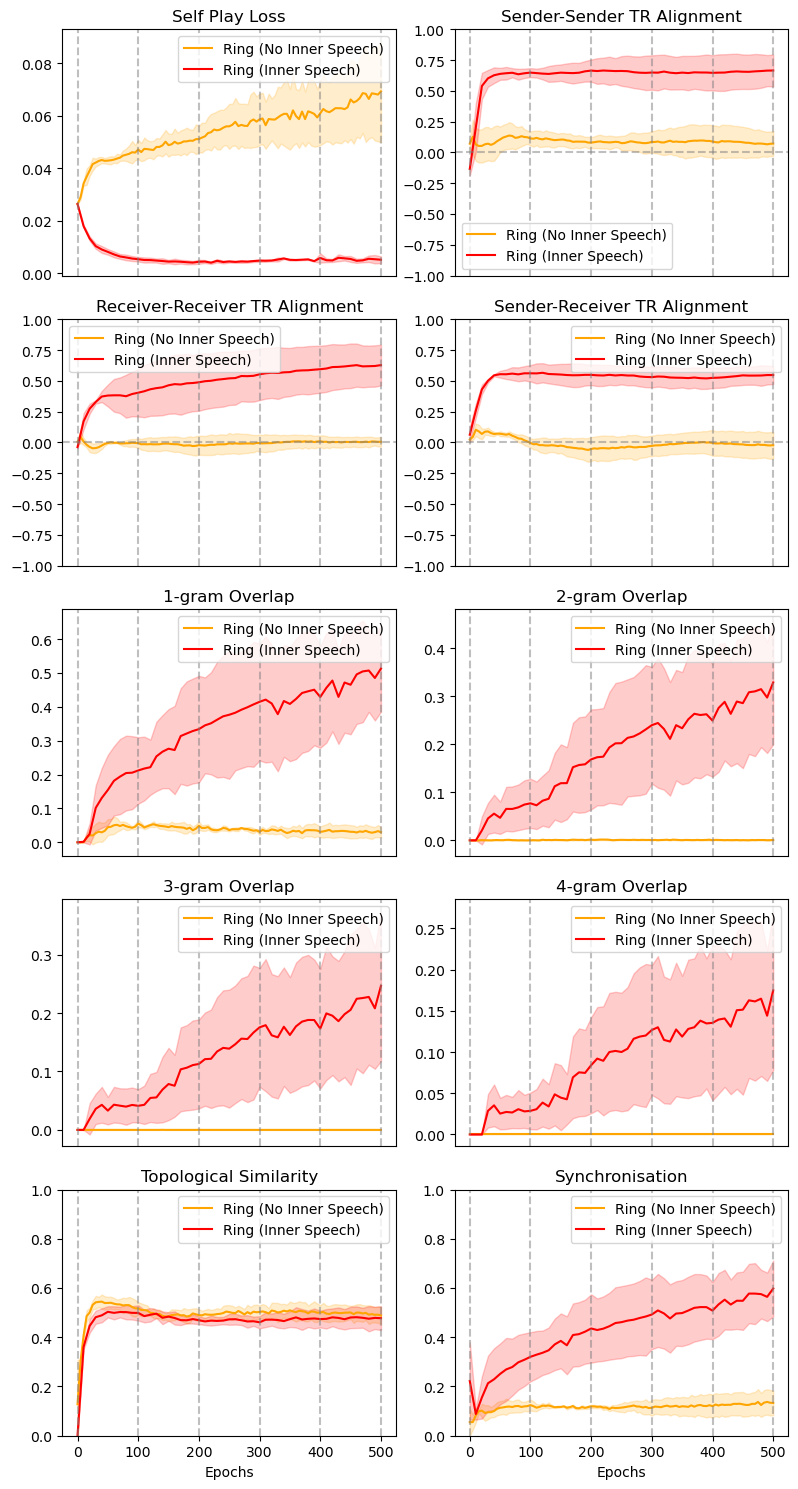

In [24]:
epoch_gap_1 = 5
epoch_gap_2 = 10

epochs_1 = 500+epoch_gap_1
epochs_2 = 500+epoch_gap_2

label_1 = "Ring (No Inner Speech)"
label_2 = "Ring (Inner Speech)"

epoch_line_period = 100

f, ax = plt.subplots(5, 2, figsize=(8, 15))

ax[0, 0].set_title("Self Play Loss")
ax[0, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["self_intelligibility_mean"], label=label_1, color = "orange")
ax[0, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                      agg_val_results_1["self_intelligibility_mean"] - std_val_results_1["self_intelligibility_mean"],
                      agg_val_results_1["self_intelligibility_mean"] + std_val_results_1["self_intelligibility_mean"],
                      alpha=0.2, color = "orange")
ax[0, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["self_intelligibility_mean"], label=label_2, color = "red")
ax[0, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                      agg_val_results_2["self_intelligibility_mean"] - std_val_results_2["self_intelligibility_mean"],
                      agg_val_results_2["self_intelligibility_mean"] + std_val_results_2["self_intelligibility_mean"],
                      alpha=0.2, color = "red")
ax[0, 0].legend()

ax[0, 1].set_title("Sender-Sender TR Alignment")
ax[0, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["ss_correlations_mean"], label=label_1, color = 'orange')
ax[0, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["ss_correlations_mean"] - std_val_results_1["ss_correlations_mean"],
                        agg_val_results_1["ss_correlations_mean"] + std_val_results_1["ss_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[0, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["ss_correlations_mean"], label=label_2, color = 'red')
ax[0, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["ss_correlations_mean"] - std_val_results_2["ss_correlations_mean"],
                        agg_val_results_2["ss_correlations_mean"] + std_val_results_2["ss_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[0, 1].legend()
ax[0, 1].set_ylim(-1, 1)
ax[0, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[1, 0].set_title("Receiver-Receiver TR Alignment")
ax[1, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["rr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["rr_correlations_mean"] - std_val_results_1["rr_correlations_mean"],
                        agg_val_results_1["rr_correlations_mean"] + std_val_results_1["rr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["rr_correlations_mean"], label=label_2, color = 'red')

ax[1, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["rr_correlations_mean"] - std_val_results_2["rr_correlations_mean"],
                        agg_val_results_2["rr_correlations_mean"] + std_val_results_2["rr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 0].legend()
ax[1, 0].set_ylim(-1, 1)
ax[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[1, 1].set_title("Sender-Receiver TR Alignment")
ax[1, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["sr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["sr_correlations_mean"] - std_val_results_1["sr_correlations_mean"],
                        agg_val_results_1["sr_correlations_mean"] + std_val_results_1["sr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["sr_correlations_mean"], label=label_2, color = 'red')
ax[1, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["sr_correlations_mean"] - std_val_results_2["sr_correlations_mean"],
                        agg_val_results_2["sr_correlations_mean"] + std_val_results_2["sr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 1].legend()
ax[1, 1].set_ylim(-1, 1)
ax[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[2, 0].set_title("1-gram Overlap")
ax[2, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["1-gram_mean"], label=label_1, color = 'orange')
ax[2, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["1-gram_mean"] - std_val_results_1["1-gram_mean"],
                        agg_val_results_1["1-gram_mean"] + std_val_results_1["1-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["1-gram_mean"], label=label_2, color = 'red')
ax[2, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["1-gram_mean"] - std_val_results_2["1-gram_mean"],
                        agg_val_results_2["1-gram_mean"] + std_val_results_2["1-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 0].legend()

ax[2, 1].set_title("2-gram Overlap")
ax[2, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["2-gram_mean"], label=label_1, color = 'orange')
ax[2, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["2-gram_mean"] - std_val_results_1["2-gram_mean"],
                        agg_val_results_1["2-gram_mean"] + std_val_results_1["2-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["2-gram_mean"], label=label_2, color = 'red')
ax[2, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["2-gram_mean"] - std_val_results_2["2-gram_mean"],
                        agg_val_results_2["2-gram_mean"] + std_val_results_2["2-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 1].legend()

ax[3, 0].set_title("3-gram Overlap")
ax[3, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["3-gram_mean"], label=label_1, color = 'orange')
ax[3, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["3-gram_mean"] - std_val_results_1["3-gram_mean"],
                        agg_val_results_1["3-gram_mean"] + std_val_results_1["3-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["3-gram_mean"], label=label_2, color = 'red')
ax[3, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["3-gram_mean"] - std_val_results_2["3-gram_mean"],
                        agg_val_results_2["3-gram_mean"] + std_val_results_2["3-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 0].legend()

ax[3, 1].set_title("4-gram Overlap")
ax[3, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["4-gram_mean"], label=label_1, color = 'orange')
ax[3, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["4-gram_mean"] - std_val_results_1["4-gram_mean"],
                        agg_val_results_1["4-gram_mean"] + std_val_results_1["4-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["4-gram_mean"], label=label_2, color = 'red')
ax[3, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["4-gram_mean"] - std_val_results_2["4-gram_mean"],
                        agg_val_results_2["4-gram_mean"] + std_val_results_2["4-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 1].legend()

ax[4, 0].set_title("Topological Similarity")
ax[4, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["topological_similarity_mean"], label=label_1, color = "orange")
ax[4, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["topological_similarity_mean"] - std_val_results_1["topological_similarity_mean"],
                        agg_val_results_1["topological_similarity_mean"] + std_val_results_1["topological_similarity_mean"],
                        alpha=0.2, color = "orange")
ax[4, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["topological_similarity_mean"], label=label_2, color = "red")
ax[4, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["topological_similarity_mean"] - std_val_results_2["topological_similarity_mean"],
                        agg_val_results_2["topological_similarity_mean"] + std_val_results_2["topological_similarity_mean"],
                        alpha=0.2, color = "red")
ax[4, 0].legend()
ax[4, 0].set_ylim(0, 1)

ax[4, 1].set_title("Synchronisation")
ax[4, 1].plot(np.arange(0, epochs_1, epoch_gap_1), 1-agg_val_results_1["edit_distance_mean"], label=label_1, color = "orange")
ax[4, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        (1-agg_val_results_1["edit_distance_mean"]) - std_val_results_1["edit_distance_mean"],
                        (1-agg_val_results_1["edit_distance_mean"]) + std_val_results_1["edit_distance_mean"],
                        alpha=0.2, color = "orange")
ax[4, 1].plot(np.arange(0, epochs_2, epoch_gap_2), 1-agg_val_results_2["edit_distance_mean"], label=label_2, color = "red")
ax[4, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        1-agg_val_results_2["edit_distance_mean"] - std_val_results_2["edit_distance_mean"],
                        1-agg_val_results_2["edit_distance_mean"] + std_val_results_2["edit_distance_mean"],
                        alpha=0.2, color = "red")
ax[4, 1].legend()
ax[4, 1].set_ylim(0, 1)

ax[4, 0].set_xlabel("Epochs")
ax[4, 1].set_xlabel("Epochs")

for i in range(0, epochs_2, epoch_line_period):
    for j in range(5):
        ax[j, 0].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax[j, 1].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        if j!=4:
            ax[j, 0].set_xticks([])
            ax[j, 1].set_xticks([])

plt.tight_layout()
plt.show()

In [25]:
# f.savefig('./FinalImages/Ring-inner-speech.pdf')

In [26]:
NUM_RUNS = 3
HIDDEN_SIZE = 32
NUM_LAYERS = 1
VOCAB_SIZE = 9

EXPT_NAME = "exp8.1"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_1 = pickle.load(f)

EXPT_NAME = "exp8.8"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_2 = pickle.load(f)


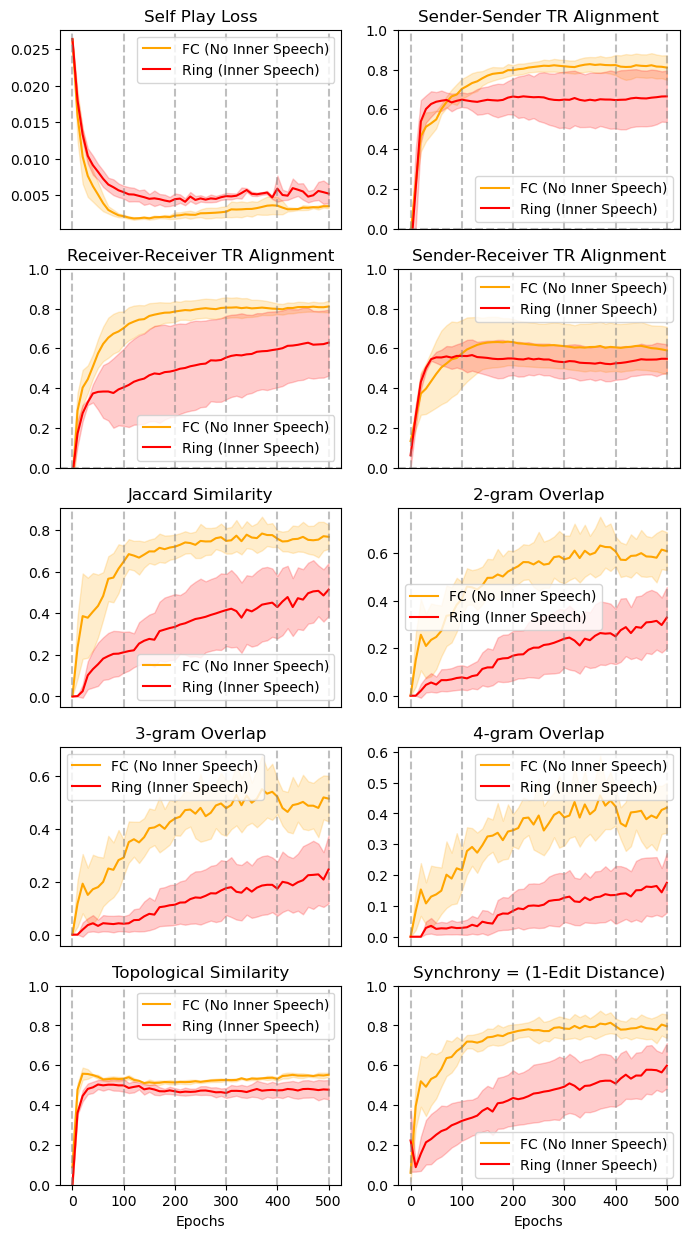

In [27]:
epoch_gap_1 = 10
epoch_gap_2 = 10

epochs_1 = 500+epoch_gap_1
epochs_2 = 500+epoch_gap_2

label_1 = "FC (No Inner Speech)"
label_2 = "Ring (Inner Speech)"

epoch_line_period = 100

f, ax = plt.subplots(5, 2, figsize=(8, 15))

ax[0, 0].set_title("Self Play Loss")
ax[0, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["self_intelligibility_mean"], label=label_1, color = "orange")
ax[0, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                      agg_val_results_1["self_intelligibility_mean"] - std_val_results_1["self_intelligibility_mean"],
                      agg_val_results_1["self_intelligibility_mean"] + std_val_results_1["self_intelligibility_mean"],
                      alpha=0.2, color = "orange")
ax[0, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["self_intelligibility_mean"], label=label_2, color = "red")
ax[0, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                      agg_val_results_2["self_intelligibility_mean"] - std_val_results_2["self_intelligibility_mean"],
                      agg_val_results_2["self_intelligibility_mean"] + std_val_results_2["self_intelligibility_mean"],
                      alpha=0.2, color = "red")
ax[0, 0].legend()

ax[0, 1].set_title("Sender-Sender TR Alignment")
ax[0, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["ss_correlations_mean"], label=label_1, color = 'orange')
ax[0, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["ss_correlations_mean"] - std_val_results_1["ss_correlations_mean"],
                        agg_val_results_1["ss_correlations_mean"] + std_val_results_1["ss_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[0, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["ss_correlations_mean"], label=label_2, color = 'red')
ax[0, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["ss_correlations_mean"] - std_val_results_2["ss_correlations_mean"],
                        agg_val_results_2["ss_correlations_mean"] + std_val_results_2["ss_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[0, 1].legend()
ax[0, 1].set_ylim(0, 1)
ax[0, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[1, 0].set_title("Receiver-Receiver TR Alignment")
ax[1, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["rr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["rr_correlations_mean"] - std_val_results_1["rr_correlations_mean"],
                        agg_val_results_1["rr_correlations_mean"] + std_val_results_1["rr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["rr_correlations_mean"], label=label_2, color = 'red')

ax[1, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["rr_correlations_mean"] - std_val_results_2["rr_correlations_mean"],
                        agg_val_results_2["rr_correlations_mean"] + std_val_results_2["rr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 0].legend()
ax[1, 0].set_ylim(0, 1)
ax[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[1, 1].set_title("Sender-Receiver TR Alignment")
ax[1, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["sr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["sr_correlations_mean"] - std_val_results_1["sr_correlations_mean"],
                        agg_val_results_1["sr_correlations_mean"] + std_val_results_1["sr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["sr_correlations_mean"], label=label_2, color = 'red')
ax[1, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["sr_correlations_mean"] - std_val_results_2["sr_correlations_mean"],
                        agg_val_results_2["sr_correlations_mean"] + std_val_results_2["sr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 1].legend()
ax[1, 1].set_ylim(0, 1)
ax[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax[2, 0].set_title("Jaccard Similarity")
ax[2, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["1-gram_mean"], label=label_1, color = 'orange')
ax[2, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["1-gram_mean"] - std_val_results_1["1-gram_mean"],
                        agg_val_results_1["1-gram_mean"] + std_val_results_1["1-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["1-gram_mean"], label=label_2, color = 'red')
ax[2, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["1-gram_mean"] - std_val_results_2["1-gram_mean"],
                        agg_val_results_2["1-gram_mean"] + std_val_results_2["1-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 0].legend()

ax[2, 1].set_title("2-gram Overlap")
ax[2, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["2-gram_mean"], label=label_1, color = 'orange')
ax[2, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["2-gram_mean"] - std_val_results_1["2-gram_mean"],
                        agg_val_results_1["2-gram_mean"] + std_val_results_1["2-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["2-gram_mean"], label=label_2, color = 'red')
ax[2, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["2-gram_mean"] - std_val_results_2["2-gram_mean"],
                        agg_val_results_2["2-gram_mean"] + std_val_results_2["2-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 1].legend()

ax[3, 0].set_title("3-gram Overlap")
ax[3, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["3-gram_mean"], label=label_1, color = 'orange')
ax[3, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["3-gram_mean"] - std_val_results_1["3-gram_mean"],
                        agg_val_results_1["3-gram_mean"] + std_val_results_1["3-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["3-gram_mean"], label=label_2, color = 'red')
ax[3, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["3-gram_mean"] - std_val_results_2["3-gram_mean"],
                        agg_val_results_2["3-gram_mean"] + std_val_results_2["3-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 0].legend()

ax[3, 1].set_title("4-gram Overlap")
ax[3, 1].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["4-gram_mean"], label=label_1, color = 'orange')
ax[3, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["4-gram_mean"] - std_val_results_1["4-gram_mean"],
                        agg_val_results_1["4-gram_mean"] + std_val_results_1["4-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 1].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["4-gram_mean"], label=label_2, color = 'red')
ax[3, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["4-gram_mean"] - std_val_results_2["4-gram_mean"],
                        agg_val_results_2["4-gram_mean"] + std_val_results_2["4-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 1].legend()

ax[4, 0].set_title("Topological Similarity")
ax[4, 0].plot(np.arange(0, epochs_1, epoch_gap_1), agg_val_results_1["topological_similarity_mean"], label=label_1, color = "orange")
ax[4, 0].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        agg_val_results_1["topological_similarity_mean"] - std_val_results_1["topological_similarity_mean"],
                        agg_val_results_1["topological_similarity_mean"] + std_val_results_1["topological_similarity_mean"],
                        alpha=0.2, color = "orange")
ax[4, 0].plot(np.arange(0, epochs_2, epoch_gap_2), agg_val_results_2["topological_similarity_mean"], label=label_2, color = "red")
ax[4, 0].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        agg_val_results_2["topological_similarity_mean"] - std_val_results_2["topological_similarity_mean"],
                        agg_val_results_2["topological_similarity_mean"] + std_val_results_2["topological_similarity_mean"],
                        alpha=0.2, color = "red")
ax[4, 0].legend()
ax[4, 0].set_ylim(0, 1)

ax[4, 1].set_title("Synchrony = (1-Edit Distance)")
ax[4, 1].plot(np.arange(0, epochs_1, epoch_gap_1), 1-agg_val_results_1["edit_distance_mean"], label=label_1, color = "orange")
ax[4, 1].fill_between(np.arange(0, epochs_1, epoch_gap_1),
                        (1-agg_val_results_1["edit_distance_mean"]) - std_val_results_1["edit_distance_mean"],
                        (1-agg_val_results_1["edit_distance_mean"]) + std_val_results_1["edit_distance_mean"],
                        alpha=0.2, color = "orange")
ax[4, 1].plot(np.arange(0, epochs_2, epoch_gap_2), 1-agg_val_results_2["edit_distance_mean"], label=label_2, color = "red")
ax[4, 1].fill_between(np.arange(0, epochs_2, epoch_gap_2),
                        1-agg_val_results_2["edit_distance_mean"] - std_val_results_2["edit_distance_mean"],
                        1-agg_val_results_2["edit_distance_mean"] + std_val_results_2["edit_distance_mean"],
                        alpha=0.2, color = "red")
ax[4, 1].legend()
ax[4, 1].set_ylim(0, 1)

ax[4, 0].set_xlabel("Epochs")
ax[4, 1].set_xlabel("Epochs")

for i in range(0, epochs_2, epoch_line_period):
    for j in range(5):
        ax[j, 0].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax[j, 1].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        if j!=4:
            ax[j, 0].set_xticks([])
            ax[j, 1].set_xticks([])

plt.show()

# Pairs

In [28]:
NUM_RUNS = 3
HIDDEN_SIZE = 32
NUM_LAYERS = 1
VOCAB_SIZE = 9

EXPT_NAME = "exp8.5.1"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_1 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_1 = pickle.load(f)

EXPT_NAME = "exp8.5.2"

with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
    agg_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
    std_epoch_losses_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
    agg_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
    std_agents_val_lossEnfToEnd_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
    agg_val_results_2 = pickle.load(f)

with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
    std_val_results_2 = pickle.load(f)


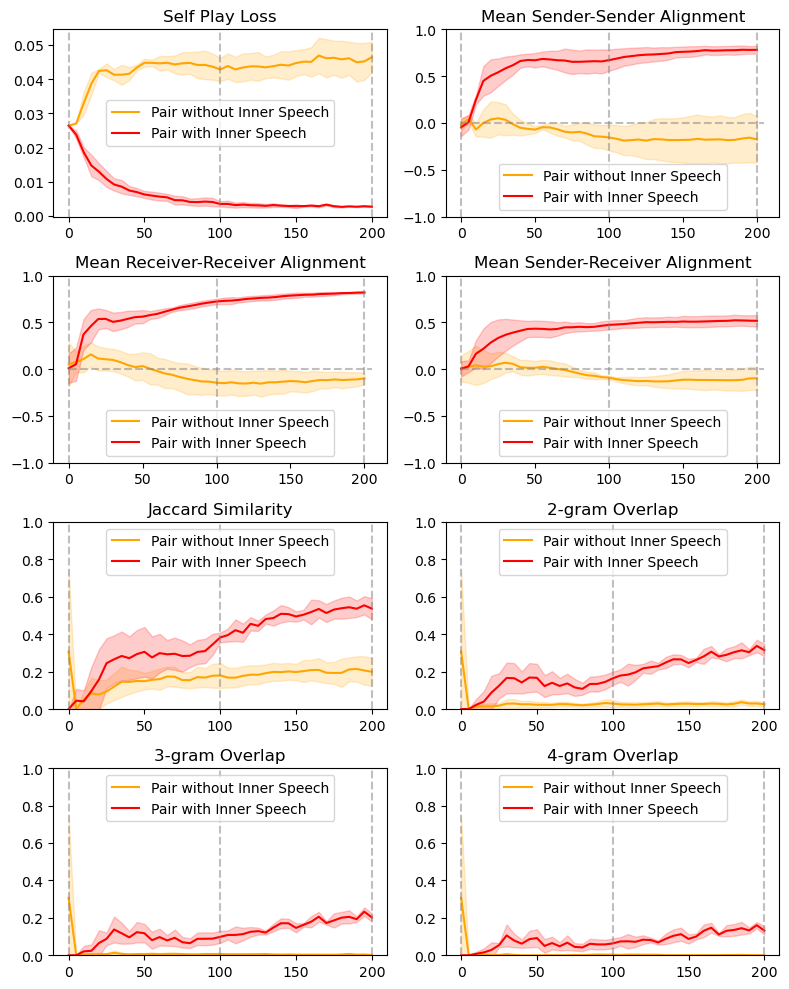

In [29]:
epochs_1 = 200+5
label_1 = "Pair without Inner Speech"
epochs_2 = 200+5
label_2 = "Pair with Inner Speech"
epoch_line_period = 100

f, ax = plt.subplots(4, 2, figsize=(8, 10))

ax[0, 0].set_title("Self Play Loss")
ax[0, 0].plot(np.arange(0, epochs_1, 5), agg_val_results_1["self_intelligibility_mean"], label=label_1, color = "orange")
ax[0, 0].fill_between(np.arange(0, epochs_1, 5),
                      agg_val_results_1["self_intelligibility_mean"] - std_val_results_1["self_intelligibility_mean"],
                      agg_val_results_1["self_intelligibility_mean"] + std_val_results_1["self_intelligibility_mean"],
                      alpha=0.2, color = "orange")
ax[0, 0].plot(np.arange(0, epochs_2, 5), agg_val_results_2["self_intelligibility_mean"], label=label_2, color = "red")
ax[0, 0].fill_between(np.arange(0, epochs_2, 5),
                      agg_val_results_2["self_intelligibility_mean"] - std_val_results_2["self_intelligibility_mean"],
                      agg_val_results_2["self_intelligibility_mean"] + std_val_results_2["self_intelligibility_mean"],
                      alpha=0.2, color = "red")
ax[0, 0].legend()

ax[0, 1].set_title("Mean Sender-Sender Alignment")
ax[0, 1].plot(np.arange(0, epochs_1, 5), agg_val_results_1["ss_correlations_mean"], label=label_1, color = 'orange')
ax[0, 1].fill_between(np.arange(0, epochs_1, 5),
                        agg_val_results_1["ss_correlations_mean"] - std_val_results_1["ss_correlations_mean"],
                        agg_val_results_1["ss_correlations_mean"] + std_val_results_1["ss_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[0, 1].plot(np.arange(0, epochs_2, 5), agg_val_results_2["ss_correlations_mean"], label=label_2, color = 'red')
ax[0, 1].fill_between(np.arange(0, epochs_2, 5),
                        agg_val_results_2["ss_correlations_mean"] - std_val_results_2["ss_correlations_mean"],
                        agg_val_results_2["ss_correlations_mean"] + std_val_results_2["ss_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[0, 1].legend()
ax[0, 1].set_ylim(-1, 1)
ax[0, 1].hlines(0, 0, max(epochs_1, epochs_2), color='gray', linestyle='--', alpha=0.5)

ax[1, 0].set_title("Mean Receiver-Receiver Alignment")
ax[1, 0].plot(np.arange(0, epochs_1, 5), agg_val_results_1["rr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 0].fill_between(np.arange(0, epochs_1, 5),
                        agg_val_results_1["rr_correlations_mean"] - std_val_results_1["rr_correlations_mean"],
                        agg_val_results_1["rr_correlations_mean"] + std_val_results_1["rr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 0].plot(np.arange(0, epochs_2, 5), agg_val_results_2["rr_correlations_mean"], label=label_2, color = 'red')
ax[1, 0].fill_between(np.arange(0, epochs_2, 5),
                        agg_val_results_2["rr_correlations_mean"] - std_val_results_2["rr_correlations_mean"],
                        agg_val_results_2["rr_correlations_mean"] + std_val_results_2["rr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 0].legend()
ax[1, 0].set_ylim(-1, 1)
ax[1, 0].hlines(0, 0, max(epochs_1, epochs_2), color='gray', linestyle='--', alpha=0.5)


ax[1, 1].set_title("Mean Sender-Receiver Alignment")
ax[1, 1].plot(np.arange(0, epochs_1, 5), agg_val_results_1["sr_correlations_mean"], label=label_1, color = 'orange')
ax[1, 1].fill_between(np.arange(0, epochs_1, 5),
                        agg_val_results_1["sr_correlations_mean"] - std_val_results_1["sr_correlations_mean"],
                        agg_val_results_1["sr_correlations_mean"] + std_val_results_1["sr_correlations_mean"],
                        alpha=0.2, color = 'orange')
ax[1, 1].plot(np.arange(0, epochs_2, 5), agg_val_results_2["sr_correlations_mean"], label=label_2, color = 'red')
ax[1, 1].fill_between(np.arange(0, epochs_2, 5),
                        agg_val_results_2["sr_correlations_mean"] - std_val_results_2["sr_correlations_mean"],
                        agg_val_results_2["sr_correlations_mean"] + std_val_results_2["sr_correlations_mean"],
                        alpha=0.2, color = 'red')
ax[1, 1].legend()
ax[1, 1].set_ylim(-1, 1)
ax[1, 1].hlines(0, 0, max(epochs_1, epochs_2), color='gray', linestyle='--', alpha=0.5)


ax[2, 0].set_title("Jaccard Similarity")
ax[2, 0].plot(np.arange(0, epochs_1, 5), agg_val_results_1["1-gram_mean"], label=label_1, color = 'orange')
ax[2, 0].fill_between(np.arange(0, epochs_1, 5),
                        agg_val_results_1["1-gram_mean"] - std_val_results_1["1-gram_mean"],
                        agg_val_results_1["1-gram_mean"] + std_val_results_1["1-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 0].plot(np.arange(0, epochs_2, 5), agg_val_results_2["1-gram_mean"], label=label_2, color = 'red')
ax[2, 0].fill_between(np.arange(0, epochs_2, 5),
                        agg_val_results_2["1-gram_mean"] - std_val_results_2["1-gram_mean"],
                        agg_val_results_2["1-gram_mean"] + std_val_results_2["1-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 0].legend()
ax[2, 0].set_ylim(0, 1)

ax[2, 1].set_title("2-gram Overlap")
ax[2, 1].plot(np.arange(0, epochs_1, 5), agg_val_results_1["2-gram_mean"], label=label_1, color = 'orange')
ax[2, 1].fill_between(np.arange(0, epochs_1, 5),
                        agg_val_results_1["2-gram_mean"] - std_val_results_1["2-gram_mean"],
                        agg_val_results_1["2-gram_mean"] + std_val_results_1["2-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[2, 1].plot(np.arange(0, epochs_2, 5), agg_val_results_2["2-gram_mean"], label=label_2, color = 'red')
ax[2, 1].fill_between(np.arange(0, epochs_2, 5),
                        agg_val_results_2["2-gram_mean"] - std_val_results_2["2-gram_mean"],
                        agg_val_results_2["2-gram_mean"] + std_val_results_2["2-gram_mean"],
                        alpha=0.2, color = 'red')
ax[2, 1].legend()
ax[2, 1].set_ylim(0, 1)

ax[3, 0].set_title("3-gram Overlap")
ax[3, 0].plot(np.arange(0, epochs_1, 5), agg_val_results_1["3-gram_mean"], label=label_1, color = 'orange')
ax[3, 0].fill_between(np.arange(0, epochs_1, 5),
                        agg_val_results_1["3-gram_mean"] - std_val_results_1["3-gram_mean"],
                        agg_val_results_1["3-gram_mean"] + std_val_results_1["3-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 0].plot(np.arange(0, epochs_2, 5), agg_val_results_2["3-gram_mean"], label=label_2, color = 'red')
ax[3, 0].fill_between(np.arange(0, epochs_2, 5),
                        agg_val_results_2["3-gram_mean"] - std_val_results_2["3-gram_mean"],
                        agg_val_results_2["3-gram_mean"] + std_val_results_2["3-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 0].legend()
ax[3, 0].set_ylim(0, 1)

ax[3, 1].set_title("4-gram Overlap")
ax[3, 1].plot(np.arange(0, epochs_1, 5), agg_val_results_1["4-gram_mean"], label=label_1, color = 'orange')
ax[3, 1].fill_between(np.arange(0, epochs_1, 5),
                        agg_val_results_1["4-gram_mean"] - std_val_results_1["4-gram_mean"],
                        agg_val_results_1["4-gram_mean"] + std_val_results_1["4-gram_mean"],
                        alpha=0.2, color = 'orange')
ax[3, 1].plot(np.arange(0, epochs_2, 5), agg_val_results_2["4-gram_mean"], label=label_2, color = 'red')
ax[3, 1].fill_between(np.arange(0, epochs_2, 5),
                        agg_val_results_2["4-gram_mean"] - std_val_results_2["4-gram_mean"],
                        agg_val_results_2["4-gram_mean"] + std_val_results_2["4-gram_mean"],
                        alpha=0.2, color = 'red')
ax[3, 1].legend()
ax[3, 1].set_ylim(0, 1)

for i in range(0, max(epochs_1, epochs_2), epoch_line_period):
    for j in range(4):
        ax[j, 0].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax[j, 1].axvline(x=i, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [30]:
# f.savefig('./FinalImages/Pair-inner-speech.pdf')

# Limitations of Synchronisation

In [31]:
import editdistance

In [32]:
def generate_ngrams(s, n):
    """Generate n-grams for a given string s."""
    return {s[i:i+n] for i in range(len(s) - n + 1)}

def sample_ngram_overlap(sample_decoded_outputs, n): # Generalisation of ROUGE-N, without a true "reference"
    n_grams = [generate_ngrams(sample_decoded_output, n) for sample_decoded_output in sample_decoded_outputs]
    intersection = set.intersection(*n_grams)
    union = set.union(*n_grams)
    if len(union)==0:
        return 0
    overlap_coefficient = len(intersection)/len(union) # Based on the formula for Jaccard Similarity
    return overlap_coefficient

def LCS(s0, s1, l, r, memo):
    if l == len(s0) or r == len(s1):
        return 0
    elif (l, r) in  memo:
        return memo[(l, r)]
    elif s0[l]==s1[r]:
        memo[(l, r)] = 1+LCS(s0, s1, l+1, r+1, memo)
        return memo[(l, r)]
    else:
        memo[(l,r)] = max(LCS(s0, s1, l, r+1, memo), LCS(s0, s1, l+1, r, memo))
        return memo[(l,r)]

In [33]:
string1 = "aham varte"
string2 = "varte'ham"

1-editdistance.distance(string1, string2)/ max(len(string1), len(string2)), sample_ngram_overlap([string1, string2], 1), sample_ngram_overlap([string1, string2], 2), sample_ngram_overlap([string1, string2], 3), sample_ngram_overlap([string1, string2], 4), LCS(string1, string2, 0, 0, {})/max(len(string1), len(string2))

(0.09999999999999998,
 0.7777777777777778,
 0.5454545454545454,
 0.36363636363636365,
 0.18181818181818182,
 0.5)

In [34]:
string1 = "अहम् वर्ते"
string2 = "वर्तेऽहम्"

1-editdistance.distance(string1, string2)/ max(len(string1), len(string2)), sample_ngram_overlap([string1, string2], 1), sample_ngram_overlap([string1, string2], 2), sample_ngram_overlap([string1, string2], 3), sample_ngram_overlap([string1, string2], 4), LCS(string1, string2, 0, 0, {})/max(len(string1), len(string2))

(0.09999999999999998,
 0.7,
 0.5454545454545454,
 0.36363636363636365,
 0.18181818181818182,
 0.5)

In [35]:
string1 = "domi est"
string2 = "est domi"

1-editdistance.distance(string1, string2)/ max(len(string1), len(string2)), sample_ngram_overlap([string1, string2], 1), sample_ngram_overlap([string1, string2], 2), sample_ngram_overlap([string1, string2], 3), sample_ngram_overlap([string1, string2], 4), LCS(string1, string2, 0, 0, {})/max(len(string1), len(string2))

(0.0, 1.0, 0.5555555555555556, 0.3333333333333333, 0.1111111111111111, 0.5)

# Demonstration of TR Alignment Calculation

In [36]:
encoderA = np.random.rand(8, 4) # 8 tokens, 4 dimensions
encoderB = np.random.rand(8, 4)

pairwiseA = cosine_similarity(encoderA.T)
pairwiseB = cosine_similarity(encoderB.T)

trA = pairwiseA[np.tril_indices(pairwiseA.shape[0], k=-1)]
trB = pairwiseB[np.tril_indices(pairwiseB.shape[0], k=-1)]

pearsonr(trA, trB)

PearsonRResult(statistic=-0.2901331330001371, pvalue=0.5770116029390536)

In [37]:
encoderA = np.array([
                        [0.2, -0.4],
                        [0.3, 0.5],
                        [0.1, 0.2],
                    ])
encoderB = np.array([   
                        [0.4, -0.5],
                        [-0.3, 0.2],
                        [0.1, 0.7],
                    ])

In [38]:
pairwiseA = cosine_similarity(encoderA, encoderA)
pairwiseA

array([[ 1.        , -0.53687549, -0.6       ],
       [-0.53687549,  1.        ,  0.99705449],
       [-0.6       ,  0.99705449,  1.        ]])

In [39]:
trA = pairwiseA[np.tril_indices(pairwiseA.shape[0], k=-1)]
trA

array([-0.53687549, -0.6       ,  0.99705449])

In [40]:
pairwiseB = cosine_similarity(encoderB, encoderB)
pairwiseB

array([[ 1.        , -0.95292578, -0.68467546],
       [-0.95292578,  1.        ,  0.4314555 ],
       [-0.68467546,  0.4314555 ,  1.        ]])

In [41]:
trB = pairwiseB[np.tril_indices(pairwiseA.shape[0], k=-1)]
trB

array([-0.95292578, -0.68467546,  0.4314555 ])

In [42]:
from scipy.stats import pearsonr

pearsonr(trA, trB)

PearsonRResult(statistic=0.9761972204243503, pvalue=0.13917915442878542)